In [11]:
# Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

# Imblearn para sampling de datos
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Visualización de árboles
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

# Statsmodels
import statsmodels.api as sm

# Eli5
import eli5
from eli5.sklearn import PermutationImportance

# PDP Plots
from pdpbox import pdp, get_dataset, info_plots

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

import pydotplus

# Semilla para procesos aleatorios
default_seed = 3928343 
np.random.seed(default_seed)

# Creación y evaluación de modelos
Este cuaderno tiene el objetivo de explicar las **características de las empresas zombis** mediante la creación y evaluación de los modelos de aprendizaje automático.

Esta explicación se lleva a cabo a partir de la inspección de las decisiones que toman los modelos para clasificar una empresa.

En un principio, el problema planteado es una clasificación binaria supervisada, donde una empresa puede ser clasificada como zombi, o como sana (no zombi). Aun así, se plantean otras alternativas de clasificación durante el desarrollo del ejercicio.

Los datos que alimentan los modelos son fruto de los ejercicios de preprocesamiento anteriores a este cuaderno. Estos ejercicios analizan, limpian y transforman dos fuentes de datos distintas:

* Los datos básicos de empresa.
* Los datos financieros de las empresas.

Para finalmente juntarlos en un único dataset que contiene las variables más relevantes.

Este cuaderno plantea la creación de modelos de caja blanca (aquellos que son directamente interpretables), y de caja negra (aquellos no interpretables directamente debido a la complejidad de sus parámetros). A modo de resumen, se analizan los siguientes modelos:

* De caja blanca.
    * Árboles de decisión.
    * Regresor logístico.
* De caja negra.
    * Máquina de vectores de soporte (SVM).
    * Redes neuronales.
    * Random Forest, como método Bagging.
    * Adaboost, como método Boosting.
    
Se empieza por los árboles de decisión, que son los modelos más interpretables, aunque de baja potencia predictiva. 

## Lectura de datos y metodología
El dataset de origen tiene las siguientes características:

1. No está balanceado. Las empresas zombis representan alrededor de un 10% del total.
2. Contiene numerosas variables numéricas. Estas contienen, en gran parte, distintas unidades. Por ejemplo:
    * El número de empleados, así como las principales variables financieras, se encuentran en escala logarítmica.
    * Existen las denominadas variaciones relativas entre ejercicios, que representan el número de ganancia respecto a ejercicios pasados.
    * Existen relaciones entre variables, que se representan mediante una proporción.
3. Existen variables ordinales como el tamaño de la empresa o la categoría rural. Estas se pueden expresar con una relación de orden.
4. También hay presentes variables categóricas en su forma comodín (o dummy). Estas toman los valores 0 o 1 dependiendo de si la categoría de la variable es cierta o no para cada instancia.

La metodología para la evaluación de los modelos es la siguiente:

Se separan los datos iniciales en dos conjuntos, train y test. El conjunto de test debe mantenerse inalterado en todos los aspectos y servirá para verificar la potencia de los modelos concretos. El conjunto de train se podrá modificar, separar de nuevo, alterar... a voluntad, con el objetivo de mejorar el rendimiento de los modelos antes de evaluaros bajo el conjunto de test.

La separación considerada es 20% para test y 80% para train, ya que existe un gran número de instancias.

Respecto a las métricas de evaluación, hay que tener en cuenta que los datos **no se encuentran balanceados**. Es decir, existe un gran número de empresas sanas. Esto puede suponer un problema al evaluar las métricas de clasificación. Por ejemplo, un clasificador que tenga una **exactitud** (accuracy) muy alta, no necesariamente es un buen modelo, ya que puede estar clasificando todas las instancias como verdaderos positivos (TP).

La métrica más importante, dada la naturaleza del problema, es el **recall**. Esta es la tasa de verdaderos positivos entre los falsos negativos. El recall proporciona una idea de la efectividad del modelo en detectar las verdaderas empresas zombis.

Sin embargo, no hay que perder de vista otras métricas, como la **precisión** (precision). La precisión indica la tasa entre verdaderos positivos y falsos positivos. Indica que, de aquellas empresas clasificadas como zombis, cuantas lo son realmente. Una precisión alta significa que los clasificadores pueden identificar los verdaderos negativos de forma eficaz.

Resulta más interesante que el recall sea alto, aunque la precisión no se puede perder de vista. Las características de las empresas zombis se podrán explicar siempre y cuando el recall sea alto. Las características de las sanas que distinguen de las empresas zombis se podrán explicar cuando la precisión sea alta.

In [12]:
# Leer el dataset y cambiar los tipos de las columnas y el índice
ez = pd.read_csv('data/EmpresasZombisClean.csv', sep=";")
ez = ez.astype({"ID":np.int64})
ez = ez.set_index("ID")
ez.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13004 entries, 233151 to 21585080121
Data columns (total 75 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   NumEmpleadosLog                  13004 non-null  float64
 1   ACC                              13004 non-null  float64
 2   ACL                              13004 non-null  float64
 3   PSC                              13004 non-null  float64
 4   PSL                              13004 non-null  float64
 5   PTT131                           13004 non-null  float64
 6   RAIE                             13004 non-null  float64
 7   VAR_REL_AC                       13004 non-null  float64
 8   VAR_REL_ACC                      13004 non-null  float64
 9   VAR_REL_ACL                      13004 non-null  float64
 10  VAR_REL_PT                       13004 non-null  float64
 11  VAR_REL_RAIE                     13004 non-null  float64
 12  Apalanc

In [13]:
# Crear los dos dataframes separados, uno para las variables independientes y el otro para las dependientes.
target = ez.isZombiOECD.map({True:1,False:0})
selection = ez.drop(['isZombiOECD'],axis=1)

In [14]:
# Test train split
x_train, x_test, y_train, y_test = train_test_split(selection,target,test_size=0.2,random_state=default_seed)

In [15]:
print("Longitud de train: {0}".format(len(x_train)))

Longitud de train: 10403


## Árboles de decisión
Los árboles de decisión forman una estructura de árbol, dónde cada nodo separa el espacio del conjunto de entrada en dos, en función de una condición bajo una variable.

El espacio se parte recursivamente hasta que se llega a un nodo hoja, dónde existe una cierta proporción de instancias de cada clase.

Cuando se clasifica una instancia, esta recorre todos los nodos del árbol a partir de la raíz, siguiendo el flujo según las condiciones de cada nodo, hasta llegar a la hoja, dónde la instancia se clasifica según la proporción de la hoja.

El modelo aprende las separaciones a realizar en cada nodo según los datos de entrenamiento. Se utiliza un criterio que maximiza la ganancia de información desde el nodo actual hacia los nodos hijos.

Los árboles de decisión son especialmente útiles para el proyecto, ya que permiten explorar de forma directa las decisiones que toman en cada nodo. Estas decisiones indican qué variables son las más determinantes para separar empresas zombis de las sanas, y por lo tanto, explican sus características.

En un primer paso, se crea un árbol simple utilizando todas las variables, con el objetivo de conocer cuáles son más importantes. Se deben tener en cuenta algunas premisas:

1. Los árboles de decisión no trabajan bien con datos no balanceados. Para solventar este problema, se puede utilizar un mecanismo de pesos para penalizar las separaciones que no incluyan correctamente la clase minoritaria. La relación de pesos ideal sería 10 para los zombi y 1 para las no zombis, pero se puede detectar automáticamente con el parámetro "class_weight" en el clasificador.
2. Si no se establece ningún criterio de parada, el árbol crecerá hasta que todas las hojas contengan 1 sola clase. Esto tampoco es deseable, ya que significa un sobre ajuste total hacia los datos de entrenamiento, además que imposibilita la comprensión del modelo. De entrada, se deben probar varias combinaciones no demasiado profundas.
3. No es necesario normalizar los datos en los árboles de decisión.

En primer lugar, se prueba un árbol de decisión con pesos según el porcentaje de las clases y con una profundidad máxima de 5 niveles, con el criterio de información de GINI como separador.

Se realiza una validación cruzada partiendo de los datos de train para obtener las puntuaciones medias de cada fold.

In [16]:
# Cross validation en un subconjunto de datos
def kfold_crossvalidation(k, clf, x_train_og, y_train_og, average='binary'):
    kf = KFold(n_splits=k)
    
    # Puntuaciones de los folds
    recalls_score = []
    precisions_score = []
    f1s_score = []
    exa_score = []
 
    # Para cada fold, calcular las métricas
    kf = KFold(n_splits=k, shuffle=True)
    for train_index , test_index in kf.split(x_train_og, y_train_og):
        
        x_train , x_test = x_train_og.iloc[train_index,:],x_train_og.iloc[test_index,:]
        y_train , y_test = y_train_og.iloc[train_index] , y_train_og.iloc[test_index]
         
        clf.fit(x_train,y_train)
        pred_values = clf.predict(x_test)
     
        exa = accuracy_score(y_test, pred_values)
        rec = recall_score(y_test, pred_values, average=average)
        pre = precision_score(y_test , pred_values, average=average)
        f1 = f1_score(y_test , pred_values, average=average)
        # Imprimir los resultados de los fols para inspeccionar su variabilidad
        print("Fold results:".format(k))
        print("-----------------------")
        print("Exactitud: {0:.2f}".format(exa))
        print("Recall: {0:.2f}".format(rec))
        print("Precisión: {0:.2f}".format(pre))
        print("F1 Score: {0:.2f}".format(f1))
        print("-----------------------")
        recalls_score.append(rec)
        precisions_score.append(pre)
        f1s_score.append(f1)
        exa_score.append(exa)
     
    # Devolver las medias de todos los folds
    return(sum(recalls_score)/k, sum(precisions_score)/k, sum(f1s_score)/k, sum(exa_score)/k)

def printKFoldResults(res):
    print("Kfold validation results:")
    print("-----------------------")
    print("Exactitud: {0:.2f}".format(res[3]))
    print("Recall: {0:.2f}".format(res[0]))
    print("Precisión: {0:.2f}".format(res[1]))
    print("F1 Score: {0:.2f}".format(res[2]))
    
def KFoldCV_Results(k, clf, x_train_og, y_train_og, average='binary'):
    printKFoldResults(kfold_crossvalidation(k, clf, x_train_og, y_train_og, average))
    
# Devuelve los resultados de un clasificador
def test_classifier(clf, x_test, y_test, classes, class_func):
    # Predice el conjunto de test
    y_pred = class_func(clf, x_test)
    # Calcula las métricas
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Calcula la matriz de confusión
    confusio = pd.DataFrame(confusion_matrix(y_test,y_pred),index=classes,columns=classes)
    return (accuracy,precision,recall,f1,confusio)

# Dibuja el ROC
def plot_roc(clf, x_test, y_test, predict):
    y_pred_proba = predict(clf, x_test)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="Area under the curve: "+str('{0:.2f}'.format(auc)))
    plt.legend(loc=4)
    plt.title("ROC Curve")
    plt.show()
    
# Imprime los resultados de un clasificador
def print_test_classifier(clf, x_test, y_test, classes = ['No zombi','Zombi'], skip_roc=False, class_func=lambda x,y: x.predict(y), predict = lambda x,y: x.predict_proba(y)[::,1]):
    res = test_classifier(clf, x_test, y_test, classes, class_func)
    print("Exactitud: {0:.2f}".format(res[0]))
    print("Precisión: {0:.2f}".format(res[1]))
    print("Recall: {0:.2f}".format(res[2]))
    print("F1 Score: {0:.2f}".format(res[3]))
    print("Matriz de confusión: ")
    print(res[4])
    if (not skip_roc):
        plot_roc(clf, x_test, y_test, predict)

In [17]:
# Crear el modelo. class_weight es la proporción de zombis, para penalizar los errores de clasifiación zombi aún más.
clf = DecisionTreeClassifier(random_state=default_seed, class_weight={0:1,1:10}, max_depth=5)
# Kfold cross validation con 5 folds
KFoldCV_Results(5, clf, x_train, y_train)

Fold results:
-----------------------
Exactitud: 0.52
Recall: 0.84
Precisión: 0.18
F1 Score: 0.29
-----------------------
Fold results:
-----------------------
Exactitud: 0.66
Recall: 0.75
Precisión: 0.24
F1 Score: 0.36
-----------------------
Fold results:
-----------------------
Exactitud: 0.63
Recall: 0.75
Precisión: 0.21
F1 Score: 0.33
-----------------------
Fold results:
-----------------------
Exactitud: 0.59
Recall: 0.82
Precisión: 0.23
F1 Score: 0.36
-----------------------
Fold results:
-----------------------
Exactitud: 0.61
Recall: 0.79
Precisión: 0.23
F1 Score: 0.35
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.60
Recall: 0.79
Precisión: 0.22
F1 Score: 0.34


Se observa un buen recall pero una baja precisión. Esto puede indicar que el modelo rinde de esta manera, ya que tiende a clasificar las instancias como zombis cuando en realidad no lo son. Esto podría pasar si los pesos de las clases no son los adecuados, o quizá por algún otro motivo.

Se realiza un grid search para determinar qué parámetros encajan mejor con el modelo del árbol de decisión. Se pone a prueba la profundidad del árbol y el mínimo de instancias en cada hoja para intentar mejorar la **precisión**.

In [18]:
# Busca los mejores parámetros a través de varios kfold
def gridSearchHeatMap(clf_origin, x_train, y_train, parameters, cross_validation_partitions, method, scoring):
    # Encontrar los parámetros
    clf = GridSearchCV(clf_origin,parameters, cv=cross_validation_partitions, scoring = scoring)
    clf.fit(x_train,y_train)
    # Imprimir los resultados
    res = pd.DataFrame(clf.cv_results_)
    params_list = list(parameters.keys())
    res['param_{0}'.format(params_list[0])] = res['param_{0}'.format(params_list[0])].map(lambda x: str(x))
    res['param_{0}'.format(params_list[1])] = res['param_{0}'.format(params_list[1])].map(lambda x: str(x))
    
    # Heatmap con los resultados
    heatmap_data = res.pivot(index='param_{0}'.format(params_list[0]),columns='param_{0}'.format(params_list[1]),values='mean_test_score')

    fig = plt.figure(figsize=(12,6))
    ax = sns.heatmap(heatmap_data, annot=True)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    fig.suptitle("{0} {1} fold cross validation {2} score by hiperparameters".format(method, cross_validation_partitions, scoring), fontsize=16)
    plt.show()

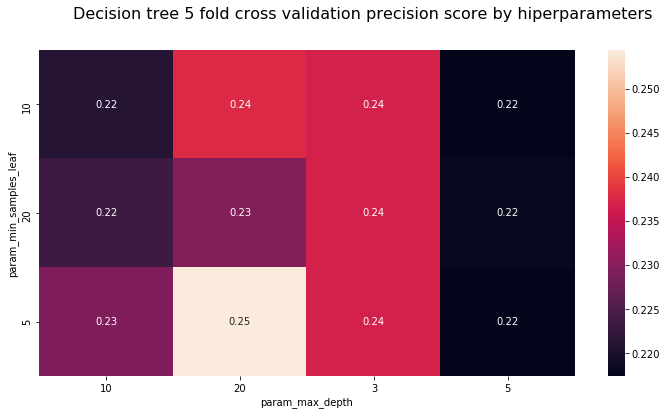

In [19]:
# Crear el modelo
clf = DecisionTreeClassifier(random_state=default_seed, class_weight={0:1,1:10})
parameters = {
    'min_samples_leaf':[5,10,20],
    'max_depth':[3,5,10,20]   
}
gridSearchHeatMap(clf, x_train, y_train, parameters, 5, "Decision tree","precision")

La precisión es muy baja, y no se observan diferencias significativas entre los distintos parámetros. 

A continuación, se inspecciona la estructura de un árbol de 3 niveles creado con los datos de entrenamiento.

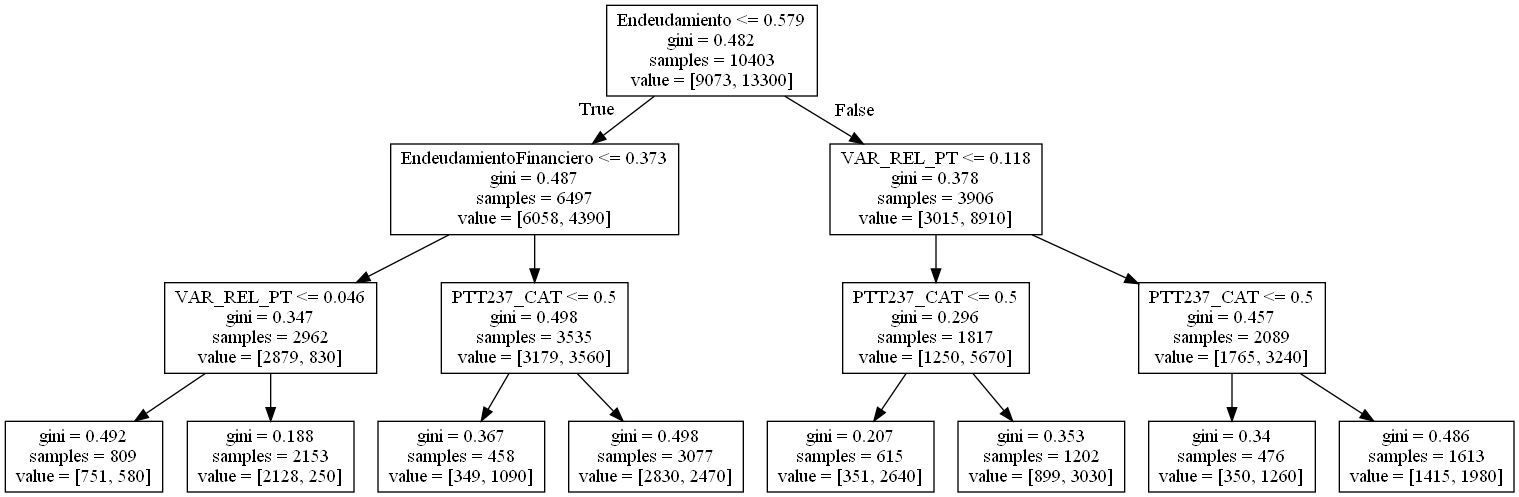

In [20]:
# Crear el modelo con profunidad máxima de 3
clf = DecisionTreeClassifier(random_state=default_seed, class_weight={0:1,1:10}, max_depth=3)
clf.fit(x_train,y_train)

def showTree(clf, feature_names):
    # Muestra el árbol
    dot_data = export_graphviz(clf, feature_names=feature_names)
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png())
    
showTree(clf, x_train.columns)

El grafo permite inspeccionar directamente las decisiones que toma el árbol para clasificar una instancia.

Hay que tener en cuenta que los valores [x,y] de cada nodo representan el número de instancias ponderadas sanas y zombis en el nodo actual, respectivamente. Por ejemplo, en el primer nodo, existen más instancias zombis, ya que se está multiplicando su influencia por 10. Para obtener el valor real, solo se necesita dividir el valor entre 10.

En primer lugar, se observa que el primer nodo separa las empresas según su nivel de endeudamiento. Un nivel alto de endeudamiento crea una separación con muchas más empresas zombis, en proporción.

Esto ya se podía prever en el cuaderno de etiquetación, ya que la variable Endeudamiento era la más importante en la selección de características. En el árbol de decisión se verifica que es la principal variable que mejor separa las empresas zombis.

Cuando el endeudamiento es mayor que 0.6, entonces se observa la variación del patrimonio. Efectivamente las empresas con una variación baja o incluso negativa tienden a acumular muchas más zombis que en el caso contrario.

Independientemente de si la variación del patrimonio es alta o baja, se mira la variable de los fondos propios. Cuando esta es 0 (fondos propios negativos en el ejercicio 2019), la concentración zombi es mucho mayor. 

Volviendo a la raíz del árbol, en el caso que el endeudamiento sea bajo, se vuelve a mirar el endeudamiento (esta vez financiero). Una vez más, un nivel alto de endeudamiento financiero supone una mayor concentración de zombis.

En resumen, el árbol explica que las empresas zombis son aquellas con un nivel de endeudamiento mayor que 0.6 (relación entre el pasivo y el activo), que tienen una tendencia a disminuir su patrimonio a lo largo de los ejercicios. Cuando sus fondos propios son negativos, aún presentan más tendencia a ser zombis.

O bien aquellas que presentan un endeudamiento inferior a 0.6, pero tienen un endeudamiento financiero superior a 0.4 y sus fondos propios son negativos. 

El problema más importante que plantean estos resultados es que el clasificador tiene un **alto recall**, pero una **baja precisión**. Esto significa que el modelo clasifica correctamente las empresas zombis, pero se lleva a muchas sanas por el camino.

Aunque cabe mencionar que **no clasifica** todas las empresas sanas como zombis, obviamente. Los resultados en la exactitud demuestran este hecho. El problema es que existe un grupo de empresas sanas que se clasifica erróneamente como zombis, ya que deben compartir las mismas características que las empresas zombis. Se plantean las siguientes hipótesis como posibles explicaciones a la baja precisión:

1. Es debido al desequilibrio de clases. Aunque este problema se debería solucionar con el parámetro "class_weights". Se pueden probar otras alternativas como el upsampling o el downsampling.
2. Existe alguna variable oculta, responsable de discriminar correctamente los falsos positivos. Esta variable se puede haber omitido durante el procesamiento de datos o quizás sea imposible de extraer con las fuentes actuales.
3. La representatividad de los datos es baja debido al número de instancias, y esto provoca que no se pueda capturar la característica que separa los FP.
4. La variable zombi es demasiado discriminante en su forma binaria. Existe pérdida de información en esa separación tan restrictiva que oculta las características deseadas para los falsos positivos.
5. Los árboles de decisión no tienen suficiente potencia para resolver la función que separa los falsos positivos.

El número de instancias es poco probable que sea el problema, ya que se ha visto que la distribución de las variables entre grupos es muy similar para casi todas las variables financieras. Además, la muestra de empresas es bastante alta.

Para descartar la primera hipótesis, se puede evaluar un modelo de árbol de decisión mediante upsampling.

El synthetic sampling reduce significativamente el problema del desequilibrio entre clases. [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) es una técnica de generación de datos sintéticos que crea nuevas instancias en un conjunto de datos.

La técnica se basa en la búsqueda de los vecinos más cercanos a una muestra del conjunto a aumentar, para luego trazar rectas entre esos puntos más cercanos y generar las nuevas instancias sobre esas rectas.

En la práctica, no es recomendable que el resultado de la generación sintética sea un dataset perfectamente balanceado(50/50), ya que se generan demasiadas instancias que pueden comprometer la variabilidad original. En cambio, se propone un ratio del 80% entre sanas y zombis.

Es importante realizar esta operación de generación sintética sobre el conjunto de **train**, dejando el de test inalterado. Generar nuevas instancias en test puede introducir bias en la evaluación de los modelos.

La librería imblanaced-learn permite realizar la operación de SMOTE incluso con datos categóricos.

In [21]:
# Genera los datos sintéticos
def generate_synthetic_data(x, x_train, y_train, sampling_strategy='auto'):
    # Recomplación de las variables categóricas
    datosBasicosCategoricas = ['CategoriaRuralInt','TamanyoInt','SA','SAS','SociedadOtros','OtrosDepartamentos','antioquia','atlantico','bogota','bolivar','caldas','cundinamarca','magdalena','meta','norte santander','risaralda','santander','tolima','valle','A','B','C','D','E','F','G','H','I','J','L','M','N','P','Q','R','S']
    financierosCategorias = [v for v in x_train.columns.tolist() if v.endswith('_CAT')]
    categoricalVars = datosBasicosCategoricas + financierosCategorias    

    # Escalar los datos para que las distancias no comprometan los vecinos más cercanos
    sc = MinMaxScaler()
    sc.fit(x)
    x_train_norm = pd.DataFrame(sc.transform(x_train),columns=x_train.columns)
    
    sm = SMOTENC(categorical_features=[x_train.columns.get_loc(i) for i in categoricalVars], random_state=default_seed, sampling_strategy=sampling_strategy)
    x_train_syn, y_train_syn = sm.fit_resample(x_train_norm, y_train)
    
    x_train_syn = pd.DataFrame(sc.inverse_transform(x_train_syn), columns=x_train.columns)
    return (x_train_syn, y_train_syn, sc)

In [22]:
# Generar datos sintéticos
x_train_syn, y_train_syn, scaler = generate_synthetic_data(selection, x_train, y_train, 0.8)
# Comprobar que no se hayan alterado las variables categóricas
print("Categorías de Ruralidad")
print(x_train_syn.CategoriaRuralInt.value_counts())
print()
print("Empresas zombis después de sintentizar: {0}. No zombis: {1}".format(len(y_train_syn[y_train_syn == 1]), len(y_train_syn[y_train_syn == 0])))

Categorías de Ruralidad
3.0    14714
2.0     1497
1.0      101
0.0       19
Name: CategoriaRuralInt, dtype: int64

Empresas zombis después de sintentizar: 7258. No zombis: 9073


Una vez se han generado los datos sintéticos, se crea un nuevo árbol con estos datos, esta vez sin necesidad de utilizar el parámetro "class_weights".

In [23]:
# Crear el modelo
clf = DecisionTreeClassifier(random_state=default_seed, max_depth=5)
# Kfold cross validation con 5 folds
printKFoldResults(kfold_crossvalidation(5, clf, x_train_syn, y_train_syn))

Fold results:
-----------------------
Exactitud: 0.75
Recall: 0.72
Precisión: 0.71
F1 Score: 0.71
-----------------------
Fold results:
-----------------------
Exactitud: 0.74
Recall: 0.65
Precisión: 0.72
F1 Score: 0.68
-----------------------
Fold results:
-----------------------
Exactitud: 0.74
Recall: 0.77
Precisión: 0.70
F1 Score: 0.73
-----------------------
Fold results:
-----------------------
Exactitud: 0.73
Recall: 0.68
Precisión: 0.71
F1 Score: 0.69
-----------------------
Fold results:
-----------------------
Exactitud: 0.75
Recall: 0.72
Precisión: 0.71
F1 Score: 0.72
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.74
Recall: 0.71
Precisión: 0.71
F1 Score: 0.71


La precisión esta vez es mucho mayor. Es necesario determinar si el aumento en la precisión se debe a una mejor clasificación de los falsos positivos o bien a un mayor número de empresas zombis.

Se pueden comparar las matrices de clasificación en los dos modelos. Uno con datos sintéticos y el otro con los datos originales.

Datos sintéticos
Exactitud: 0.74
Precisión: 0.71
Recall: 0.68
F1 Score: 0.69
Matriz de confusión: 
          No zombi  Zombi
No zombi      1423    401
Zombi          463    980


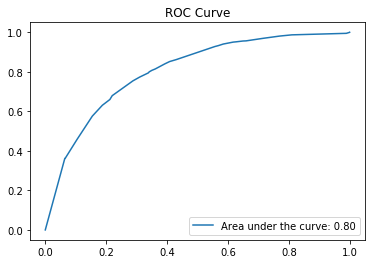

Sin datos sintéticos
Exactitud: 0.52
Precisión: 0.18
Recall: 0.84
F1 Score: 0.29
Matriz de confusión: 
          No zombi  Zombi
No zombi       883    951
Zombi           40    207


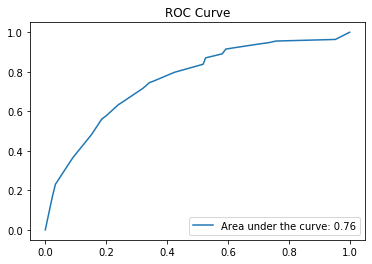

In [24]:
def test_classifier_train_fold(x_train, y_train, clf, skip_roc=False):
    # Crear 1 fold dentro de train
    x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_train,y_train,test_size=0.2,random_state=default_seed)
    clf.fit(x_train_1, y_train_1)
    print_test_classifier(clf, x_test_1, y_test_1, ['No zombi','Zombi'], skip_roc)
    
    
clfSyn = DecisionTreeClassifier(random_state=default_seed, max_depth=5)
clfNoSyn = DecisionTreeClassifier(random_state=default_seed, max_depth=5, class_weight={0:1,1:10})
print("Datos sintéticos")
test_classifier_train_fold(x_train_syn, y_train_syn, clfSyn)
print("Sin datos sintéticos")
test_classifier_train_fold(x_train, y_train, clfNoSyn)

Aunque el recall sufre una ligera caída, existe una mejora notable en la precisión. Un gran número de falsos positivos se ha clasificado correctamente esta vez. Cabe destacar que la generación de datos sintéticos solo afecta a la clase zombi, por lo que esta mejora se tiene que atribuir al modelo.

Estas diferencias se tiene que evaluar bajo el conjunto de test, que ha permanecido inalterado.

Datos sintéticos
Exactitud: 0.74
Precisión: 0.22
Recall: 0.55
F1 Score: 0.32
Matriz de confusión: 
          No zombi  Zombi
No zombi      1755    555
Zombi          131    160


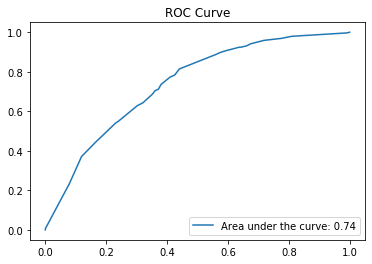

Sin datos sintéticos
Exactitud: 0.51
Precisión: 0.16
Recall: 0.82
F1 Score: 0.27
Matriz de confusión: 
          No zombi  Zombi
No zombi      1092   1218
Zombi           52    239


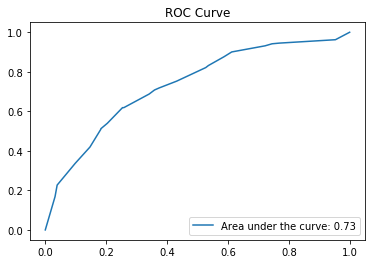

In [25]:
# Evaluación en TEST
print("Datos sintéticos")
print_test_classifier(clfSyn, x_test, y_test)
print("Sin datos sintéticos")
print_test_classifier(clfNoSyn, x_test, y_test)

La precisión vuelve a ser bastante baja en ambos modelos, y denota que, utilizando datos sintéticos, se aprende a diferenciar mejor los falsos positivos, pero no lo suficiente para justificar la pérdida de recall. 

Se puede observar el árbol generado con los datos sintéticos para intentar detectar alguna diferencia entre los dos.

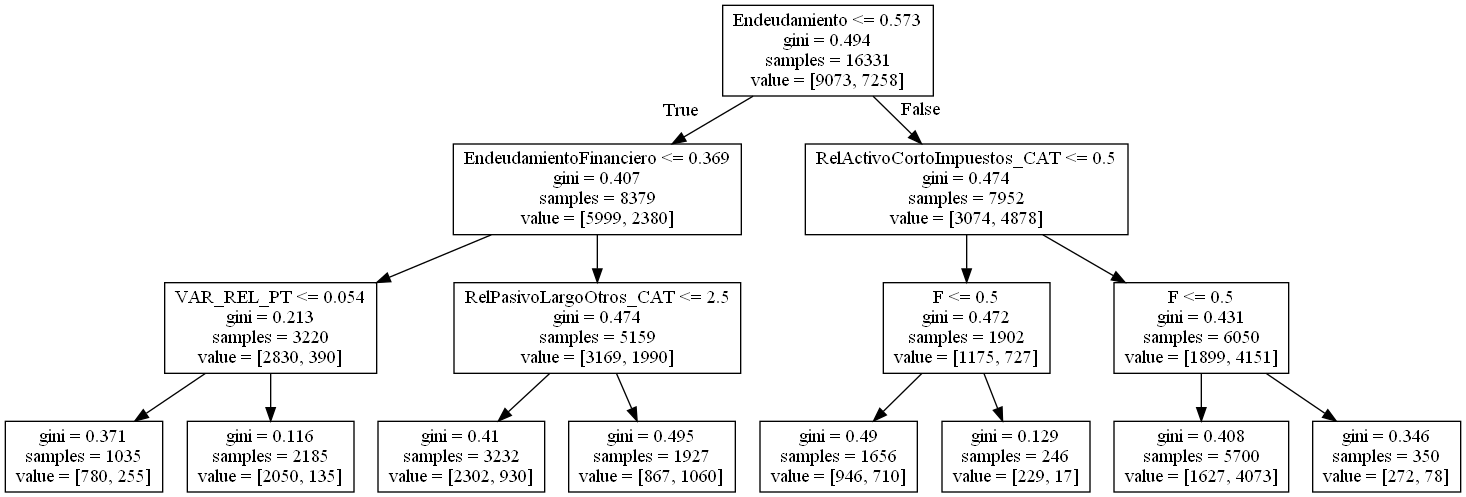

In [26]:
clfSyn2 = DecisionTreeClassifier(max_depth=3)
clfSyn2.fit(x_train_syn, y_train_syn)
showTree(clfSyn2, x_train_syn.columns)

La única diferencia relevante es la aparición de la variable RelActivoCortoImpuestos_CAT en las posiciones superiores al árbol. Esta variable indica la proporción del activo dedicado a los impuestos corrientes. El clasificador Perjudica gravemente a las empresas que tienen una parte de su activo dedicado a los impuestos corrientes (ya que 0 denota sin participación). Este activo significa que la empresa ha realizado un pago mayor de lo estipulado por sus impuestos y la diferencia queda reflejada en este activo. 

A continuación, se puede también verificar si el downsampling (reducir el tamaño de la muestra no zombi), produce mejores o peores resultados para el problema del desequilibrio.

In [27]:
# Bajar el tamaño de la muestra no zombi
def undersample_train(x_train, y_train):
    rus = RandomUnderSampler()
    x_train_un, y_train_un = rus.fit_resample(x_train, y_train)
    return (x_train_un, y_train_un)

In [28]:
x_train_un, y_train_un = undersample_train(x_train, y_train)
clfUn = DecisionTreeClassifier(random_state=default_seed, max_depth=5)
KFoldCV_Results(5, clfUn, x_train_un, y_train_un)

Fold results:
-----------------------
Exactitud: 0.67
Recall: 0.72
Precisión: 0.66
F1 Score: 0.68
-----------------------
Fold results:
-----------------------
Exactitud: 0.72
Recall: 0.78
Precisión: 0.70
F1 Score: 0.74
-----------------------
Fold results:
-----------------------
Exactitud: 0.69
Recall: 0.71
Precisión: 0.68
F1 Score: 0.69
-----------------------
Fold results:
-----------------------
Exactitud: 0.67
Recall: 0.66
Precisión: 0.68
F1 Score: 0.67
-----------------------
Fold results:
-----------------------
Exactitud: 0.70
Recall: 0.75
Precisión: 0.68
F1 Score: 0.71
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.69
Recall: 0.72
Precisión: 0.68
F1 Score: 0.70


Exactitud: 0.61
Precisión: 0.19
Recall: 0.75
F1 Score: 0.30
Matriz de confusión: 
          No zombi  Zombi
No zombi      1370    940
Zombi           72    219


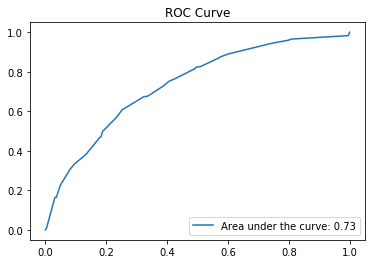

In [29]:
# Evaluar el downsampling en test
clfUn = DecisionTreeClassifier(random_state=default_seed, max_depth=5)
clfUn.fit(x_train_un, y_train_un)
print_test_classifier(clfUn, x_test, y_test)

La problemática sigue siguiendo la misma, y la puntuación se encuentra entre el upsampling y el dataset normal.

Por lo tanto, se debe descartar que el problema de la precisión sea debido al desequilibrio del dataset, y se tienen que poner a prueba las otras hipótesis.

Para ello, se puede crear una nueva variable objetivo no binaria, que tenga múltiples clases, con la esperanza de poder clasificar correctamente los falsos positivos.

La idea para esta variable es la siguiente: capturar la zombicidad de las empresas. La variable presenta la siguiente forma:

1. Empresas que están volviéndose zombis o que son zombis.
    1. En el último año tienen un ratio de cobertura de interés inferior a 1, pero en los otros no: 1
    2. En los últimos dos años tienen un ratio de cobertura de interés inferior a 1, pero en el otro no: 2
    3. En todos los años tienen un ratio de cobertura de interés inferior a 1: 3.
2. Empresas que se están recuperando o que no son zombis.
    1. En los dos primeros años el ratio es menor que 1, pero en el último no: -1.
    2. En el primer año el ratio menor que 1, pero en los otros dos superiores: -2.
    3. Todos los ejercicios sanos: -3
3. En caso de flujos entre ratios menores y mayores que 1 se asigna 0.

Si esta hipótesis no tiene efecto, significa que no se ha podido capturar correctamente la variable o factores que distinguen las empresas sanas que se comportan financialmente como zombis.

In [30]:
# Leer los ejercicios
ejercicios = pd.read_csv('data/EjerciciosClean.csv', sep=";")

# Etiqutar las empresas
def etiquetarZombi(group):
    row = dict()
    empresaId = group['ID'].unique()[0]
    
    ratios = []
    for year in [2017,2018,2019]:
        ragxfiCell = group.loc[group['Anyo'] == year,'RAGXFI']
        yearCell =  group.loc[group['Anyo'] == year,'RA']
        if (len(ragxfiCell) == 0 or len(yearCell) == 0):
            return None
        ragxfi = ragxfiCell.iloc[0]
        ratio = np.inf
        if (ragxfi > 0):
            ratio = yearCell.iloc[0] / ragxfi
        ratios = ratios + [ratio]

    ratio2017 = ratios[0]
    ratio2018 = ratios[1]
    ratio2019 = ratios[2]
    catZombi = 0

    if (ratio2019 < 1 and ratio2018 >= 1 and ratio2017 >= 1):
        catZombi = 1
    elif (ratio2019 < 1 and ratio2018 < 1 and ratio2017 >= 1):
        catZombi = 2
    elif (ratio2019 < 1 and ratio2018 < 1 and ratio2017 < 1):
        catZombi = 3
    elif (ratio2017 < 1 and ratio2018 < 1 and ratio2019 >= 1):
        catZombi = -1
    elif (ratio2017 < 1 and ratio2018 >= 1 and ratio2019 >= 1):
        catZombi = -2
    elif (ratio2017 >= 1 and ratio2018 >= 1 and ratio2019 >= 1):
        catZombi = -3
    else:
        catZombi = 0
        
    row['zombi_CAT'] = catZombi
    row['ID'] = empresaId
    
    return pd.Series(row)
 
# Crear los grupos y etiquetar las empresas
EZCat = ejercicios.groupby('ID').apply(etiquetarZombi)
EZCat = EZCat.reset_index(drop=True)
EZCat.head()

zombi_CAT        ID
0       -3.0  233151.0
1        0.0  233207.0
2       -2.0  233235.0
3       -3.0  233284.0
4       -1.0  233291.0

In [31]:
EZCat = EZCat.dropna()
EZCat.to_csv("data/EmpresasZombisCat.csv",sep=";",index=False)

In [32]:
# Enlazar con los datos de empresa y financieros
EZCat = pd.read_csv("data/EmpresasZombisCat.csv",sep=";")
EZCat.astype({"ID":np.int64})
EZCat = EZCat.set_index("ID")

# Leer el dataset y cambiar los tipos de las columnas y el índice
ez = pd.read_csv('data/EmpresasZombisClean.csv', sep=";")
ez = ez.astype({"ID":np.int64})
ez = ez.set_index("ID")

# Merge de datos
temp = ez.merge(EZCat, on="ID", how="inner")
temp = temp.drop(['isZombiOECD'],axis=1)

# Selección de características y splits
target_cat = temp.zombi_CAT
selection_cat = temp.drop(['zombi_CAT'],axis=1)

# El split es mayor esta vez para que haya más representabilidad de las clases en test
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(selection_cat,target_cat,test_size=0.4,random_state=default_seed)

print("Conteo de clases en train:")
print(y_train_cat.value_counts())

Conteo de clases en train:
-3.0    4435
 3.0     963
 0.0     552
 1.0     483
-2.0     473
 2.0     400
-1.0     330
Name: zombi_CAT, dtype: int64


Se observa que existe una buena representación en todas las clases, aunque esté desequilibrada.

Se pone a prueba el árbol de decisión bajo esta nueva variable para evaluar su rendimiento.

In [33]:
# Observar los value counts de categoria rural
print(x_train_cat.CategoriaRuralInt.value_counts())

3.0    6647
2.0     907
1.0      71
0.0      11
Name: CategoriaRuralInt, dtype: int64


Para empezar, se realiza un grid search con validación cruzada evaluando el rendimiento de los diferentes parámetros. Se pone a prueba la métrica f1_macro para comparar modelos.

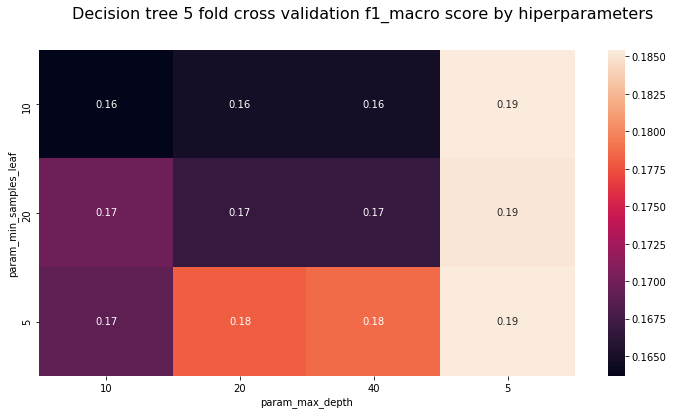

In [34]:
parameters = {
    'min_samples_leaf':[5,10,20],
    'max_depth':[5,10,20,40]   
}
clf = DecisionTreeClassifier(random_state=default_seed, class_weight='balanced')

gridSearchHeatMap(clf, x_train_cat, y_train_cat, parameters, 5, "Decision tree","f1_macro")

Los resultados indican un bajo valor de f1 macro y muy similar en todos los parámetros. Se evalúa el clasificador para determinar el origen del problema.

In [35]:
def report_cls(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print("Matriz de confusión: ")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("Reporte:")
    print(classification_report(y_test, y_pred))
    
def test_train_fold_multiclass(clf, x_train_cat, y_train_cat, split_size):
    x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_train_cat,y_train_cat,test_size=0.4,random_state=default_seed)
    
    clf.fit(x_train_1, y_train_1)

    report_cls(clf, x_test_1, y_test_1)


clf = DecisionTreeClassifier(random_state=default_seed, max_depth=40, min_samples_leaf=5, class_weight='balanced')
test_train_fold_multiclass(clf, x_train_cat, y_train_cat, 0.4)

Matriz de confusión: 
[[583 221 161 247 199 182 168]
 [ 49  35  24  19  17  25  28]
 [ 17  20  20  22  14  13  22]
 [ 44  26  24  38  26  33  34]
 [ 27  16  29  25  27  37  38]
 [ 15  11  23  23  22  29  30]
 [ 40  41  44  43  43  69 112]]

Reporte:
              precision    recall  f1-score   support

        -3.0       0.75      0.33      0.46      1761
        -2.0       0.09      0.18      0.12       197
        -1.0       0.06      0.16      0.09       128
         0.0       0.09      0.17      0.12       225
         1.0       0.08      0.14      0.10       199
         2.0       0.07      0.19      0.11       153
         3.0       0.26      0.29      0.27       392

    accuracy                           0.28      3055
   macro avg       0.20      0.21      0.18      3055
weighted avg       0.49      0.28      0.33      3055



Los resultados denotan sobreajuste por la clase con menos indicios de zombicidad, que es la mayoritaria. Se puede probar con el upsampling.

In [36]:
x_train_cat_syn, y_train_cat_syn, scaler_syn = generate_synthetic_data(selection_cat, x_train_cat, y_train_cat)
print(y_train_cat_syn.value_counts())

-1.0    4435
 0.0    4435
 3.0    4435
-2.0    4435
 1.0    4435
-3.0    4435
 2.0    4435
Name: zombi_CAT, dtype: int64


In [37]:
clf = DecisionTreeClassifier(random_state=default_seed, max_depth=40, min_samples_leaf=5)
clf.fit(x_train_cat_syn, y_train_cat_syn)

report_cls(clf, x_test_cat, y_test_cat)

Matriz de confusión: 
[[1308  358  223  345  310  173  209]
 [ 103   41   33   45   37   16   34]
 [  61   29   21   29   24   22   38]
 [ 117   48   40   42   48   36   51]
 [ 101   33   26   39   50   48   41]
 [  62   29   30   37   43   42   48]
 [ 122   69   60   67   66   70  167]]

Reporte:
              precision    recall  f1-score   support

        -3.0       0.70      0.45      0.55      2926
        -2.0       0.07      0.13      0.09       309
        -1.0       0.05      0.09      0.06       224
         0.0       0.07      0.11      0.09       382
         1.0       0.09      0.15      0.11       338
         2.0       0.10      0.14      0.12       291
         3.0       0.28      0.27      0.28       621

    accuracy                           0.33      5091
   macro avg       0.19      0.19      0.18      5091
weighted avg       0.46      0.33      0.38      5091



El rendimiento es bastante peor que en el árbol binario, ya que los resultados aún con datos sintéticos son peores que en el caso sintético del árbol de decisión binario. Los clasificadores tienen un bias hacia la clase no zombi.

Se puede enfocar el problema con una metodología distinta, la **regresión**. Esta vez, se utiliza un regresor para intentar ajustar las variables independientes a la zombicidad de la empresa. Las categorías ya se han estipulado de una manera lógica, que implica un orden de menor a mayor zombicidad de las empresas.

Se balancea el dataset mediante el undersampling.

In [38]:
x_train_cat_un, y_train_cat_un = undersample_train(x_train_cat, y_train_cat)
print(y_train_cat_un.value_counts())

 3.0    330
 2.0    330
 1.0    330
 0.0    330
-1.0    330
-2.0    330
-3.0    330
Name: zombi_CAT, dtype: int64


In [39]:
clf_rf = RandomForestRegressor(random_state=default_seed, n_estimators=100)
clf_rf.fit(x_train_cat_un, y_train_cat_un)
y_pred = clf_rf.predict(x_test_cat)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_cat, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_cat, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_cat, y_pred)))
print("r2:", metrics.r2_score(y_test_cat, y_pred))

Mean Absolute Error: 2.062194067963072
Mean Squared Error: 5.330004065998821
Root Mean Squared Error: 2.3086801567126662
r2: -0.05570730203468166


Utilizando el regresor de random forest, los resultados no son demasiado buenos. El error medio absoluto se sitúa en 2 unidades, lo que significa que el clasificador se equivoca en 2 categorías, de media. Tampoco parece que exista una correlación entre la función de regresión y la variable objetiva en test, ya que el coeficiente r2 es muy cercano a 0.

Por lo tanto, se descarta que un modelo de multiclasse o de regresión mejore la calidad de las predicciones.

Por último, se puede comprobar qué sucede si se eliminan todas las variables financieras del dataset, dejando únicamente las básicas de empresa. Si el clasificador tiene unas métricas similares a las vistas hasta el momento, quizá se puedan explicar un poco más las variables básicas de empresa, que no aparecen en los otros modelos, ya que se filtran por ser poco relevantes.

In [40]:
datosBasicos = ['NumEmpleadosLog','TamanyoInt','CategoriaRuralInt','SA','SAS','SociedadOtros','OtrosDepartamentos','antioquia','atlantico','bogota','bolivar','caldas','cundinamarca','magdalena','meta','norte santander','risaralda','santander','tolima','valle','A','B','C','D','E','F','G','H','I','J','L','M','N','P','Q','R','S']

x_train_bas, x_test_bas, y_train_bas, y_test_bas = train_test_split(selection[datosBasicos],target,test_size=0.2,random_state=default_seed)

In [41]:
# Crear el modelo
clf = DecisionTreeClassifier(random_state=default_seed, class_weight='balanced', max_depth=3)
# Kfold cross validation con 5 folds
printKFoldResults(kfold_crossvalidation(5, clf, x_train_bas, y_train_bas))

Fold results:
-----------------------
Exactitud: 0.65
Recall: 0.49
Precisión: 0.20
F1 Score: 0.28
-----------------------
Fold results:
-----------------------
Exactitud: 0.65
Recall: 0.46
Precisión: 0.18
F1 Score: 0.26
-----------------------
Fold results:
-----------------------
Exactitud: 0.67
Recall: 0.45
Precisión: 0.17
F1 Score: 0.25
-----------------------
Fold results:
-----------------------
Exactitud: 0.58
Recall: 0.52
Precisión: 0.15
F1 Score: 0.24
-----------------------
Fold results:
-----------------------
Exactitud: 0.44
Recall: 0.73
Precisión: 0.14
F1 Score: 0.23
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.60
Recall: 0.53
Precisión: 0.17
F1 Score: 0.25


Los resultados son peores que utilizando datos financieros. Tanto la precisión como el recall sufren una pequeña caída. Todo es un indicativo de que estas variables no tienen potencia predictora alguna para determinar si una empresa es zombi o no.

Se observa el árbol de decisión creado para averiguar qué criterios se tienen en cuenta:

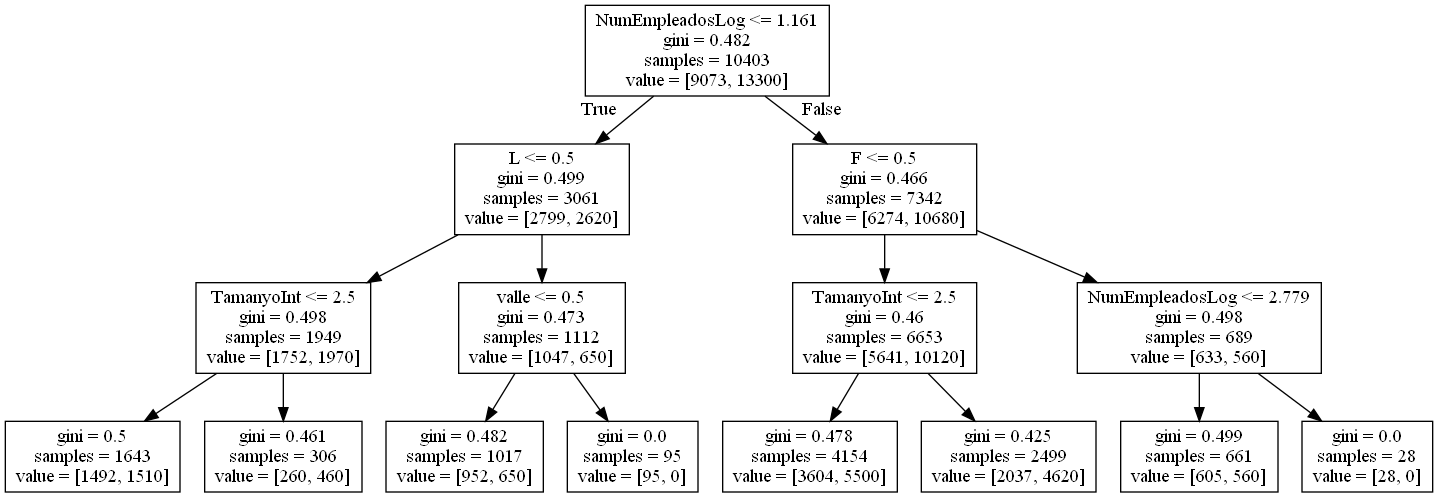

In [42]:
# Crear el modelo con profunidad máxima de 3
clf = DecisionTreeClassifier(random_state=default_seed, class_weight={0:1,1:10}, max_depth=3)
clf.fit(x_train_bas,y_train_bas)
# Muestra el árbol
showTree(clf, x_train_bas.columns)

Se observa que a mayor número de empleados, mayor presencia zombi. La variable categórica de la denominación del tamaño también indica lo mismo.

Los sectores de la construcción y el inmobiliario presentan menos proporción de zombis, según el árbol.

Las otras variables no separan las proporciones con tanta significancia como la raíz. La excepción es Valle, que curiosamente no presenta zombis en el sector inmobiliario cuando el número de empleados es bajo.

Para finalizar con la sección de los árboles, se inspecciona este último modelo sobre el conjunto de test.

Exactitud: 0.65
Precisión: 0.16
Recall: 0.48
F1 Score: 0.23
Matriz de confusión: 
          No zombi  Zombi
No zombi      1554    756
Zombi          152    139


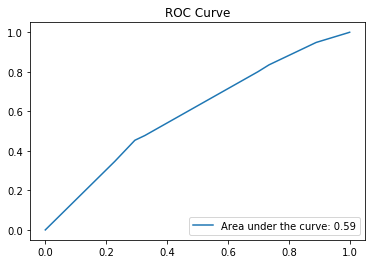

In [43]:
clfBas = DecisionTreeClassifier(random_state=default_seed, max_depth=3, class_weight='balanced')

clfBas.fit(x_train_bas, y_train_bas)

print_test_classifier(clfBas, x_test_bas, y_test_bas, ['No zombi','Zombi'])

Efectivamente, suceden los mismos problemas que cuando el árbol se intenta ajustar con los datos financieros, aunque las métricas son peores.

En resumen, todo indica que, o bien faltan variables, o bien la función zombi no se puede representar correctamente con los árboles de decisión.

Las características encontradas hasta el momento que mejor representan a las empresas zombis, aunque muchas de las empresas sanas comparten son:

1. Un alto nivel de endeudamiento.
2. Una variación baja o negativa de su patrimonio a través de los ejercicios.
3. Sus fondos propios tienden a ser negativos en el último ejercicio.
4. Tienen más prevalencia en las empresas con mayor número de empleados y de mayor calificación de tamaño.
5. El sector de la construcción no tiende a acumular empresas zombis.

Los resultados presentan bastante relación con los anteriores estudios. En concreto, Hoshi (2006), estipula que las empresas zombis se concentran principalmente en los sectores de la construcción y el inmobiliario, pero no es el caso detectado por este análisis, sino todo lo contrario.

Sí que se coincide en qué las empresas zombis presentan un nivel de deuda muy alto en relación con sus activos, como estipula la variable del Endeudamiento.

Pero tampoco parece que el estudio coincida con el número de empleados, ya que un mayor número de empleados conlleva a una más alta concentración de zombis. Sí que se coincide en este aspecto con Adalet McGowan et al (2017), ya que describe a las empresas zombis como aquellas con mayor número de empleados.

Respecto a otros estudios, no se coincide demasiado con sus resultados, o bien no se pueden comparar, ya que los datos disponibles son distintos.

Finalmente, mencionar que la baja precisión sea muy probablemente causada por variables ocultas. Estas variables, no existentes en el modelo por culpa del procesado de datos o bien por qué no existían en origen, son las que deberían diferenciar una empresa sana que presenta todos los síntomas de una empresa zombi, pero no lo es debido a que su ratio de cobertura de interés es alto en todos los ejercicios.

A continuación, se ponen a prueba otros modelos de aprendizaje automático.

## Regresión logística
La regresión logística es un tipo de regresión que ajusta la salida a una probabilidad entre 0 y 1, que representa la probabilidad de que un suceso ocurra.

Este tipo de regresión se puede utilizar para predecir la probabilidad de que una empresa sea zombi, y así crear un clasificador binario.

La regresión logística es un algoritmo de caja blanca, ya que permite obtener directamente la importancia de cada variable en la ecuación final. Cuanto más alta sea el coeficiente de regresión de la variable, más contribuye a clasificar una instancia como positiva.

La regresión logística no requiere de normalización por lo que se pueden utilizar los mismos datos que alimentaban los árboles de decisión.

In [44]:
# Crear el modelo
clf = LogisticRegression(random_state=default_seed, class_weight={0:1,1:10}, max_iter=1000)
# Kfold cross validation con 5 folds
printKFoldResults(kfold_crossvalidation(5, clf, x_train, y_train))

Fold results:
-----------------------
Exactitud: 0.66
Recall: 0.84
Precisión: 0.25
F1 Score: 0.39
-----------------------
Fold results:
-----------------------
Exactitud: 0.67
Recall: 0.82
Precisión: 0.25
F1 Score: 0.39
-----------------------
Fold results:
-----------------------
Exactitud: 0.67
Recall: 0.83
Precisión: 0.27
F1 Score: 0.41
-----------------------
Fold results:
-----------------------
Exactitud: 0.64
Recall: 0.84
Precisión: 0.23
F1 Score: 0.36
-----------------------
Fold results:
-----------------------
Exactitud: 0.66
Recall: 0.82
Precisión: 0.24
F1 Score: 0.37
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.66
Recall: 0.83
Precisión: 0.25
F1 Score: 0.38


Las métricas de recall y de precisión son mejores que las obtenidas anteriormente, pero la interpretación sigue siendo la misma. La precisión es baja, y por lo tanto se están clasificando empresas sanas como zombis.

Se intenta mejorar la regresión con una búsqueda de los mejores parámetros:

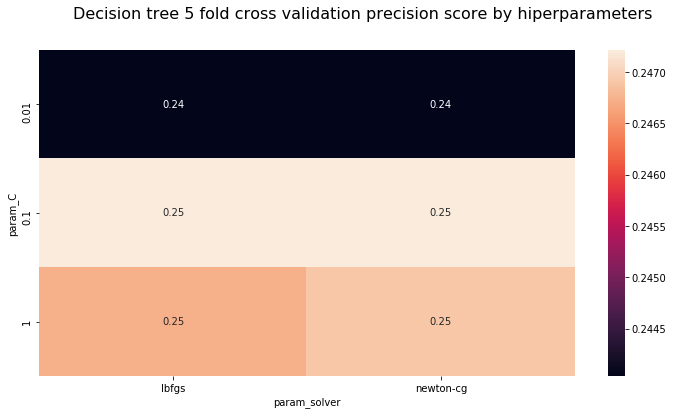

In [45]:
# Crear el modelo
clf = LogisticRegression(random_state=default_seed, class_weight={0:1,1:10}, max_iter=1000)
parameters = {
    'C':[0.01,0.1,1],
    'solver':['newton-cg','lbfgs']   
}

gridSearchHeatMap(clf, x_train, y_train, parameters, 5, "Decision tree","precision")

No hay diferencias entre el uso de distintos parámetros. Se evalúa la diferencia entre entrenar con datos sintéticos y con los datos originales.

In [46]:
# Crear el modelo
clf = LogisticRegression(random_state=default_seed, max_iter=1000)
# Kfold cross validation con 5 folds
printKFoldResults(kfold_crossvalidation(5, clf, x_train_syn, y_train_syn))

Fold results:
-----------------------
Exactitud: 0.87
Recall: 0.83
Precisión: 0.88
F1 Score: 0.85
-----------------------
Fold results:
-----------------------
Exactitud: 0.88
Recall: 0.82
Precisión: 0.89
F1 Score: 0.86
-----------------------
Fold results:
-----------------------
Exactitud: 0.88
Recall: 0.83
Precisión: 0.89
F1 Score: 0.86
-----------------------
Fold results:
-----------------------
Exactitud: 0.87
Recall: 0.81
Precisión: 0.88
F1 Score: 0.84
-----------------------
Fold results:
-----------------------
Exactitud: 0.87
Recall: 0.83
Precisión: 0.88
F1 Score: 0.85
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.87
Recall: 0.82
Precisión: 0.89
F1 Score: 0.85


Los resultados son bastante buenos. Aun así se debe andar con cuidado, ya que los buenos resultados pueden ser un reflejo causado por el incremento de instancias zombis. Se observan las diferencias entre los clasificadores de regresión logística con y sin datos sintéticos en un fold del conjunto de train.

Exactitud: 0.87
Precisión: 0.88
Recall: 0.82
F1 Score: 0.85
Matriz de confusión: 
          No zombi  Zombi
No zombi      1667    157
Zombi          253   1190


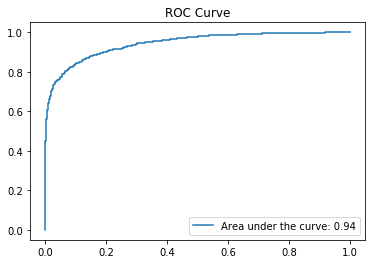

Exactitud: 0.64
Precisión: 0.23
Recall: 0.87
F1 Score: 0.37
Matriz de confusión: 
          No zombi  Zombi
No zombi      1124    710
Zombi           33    214


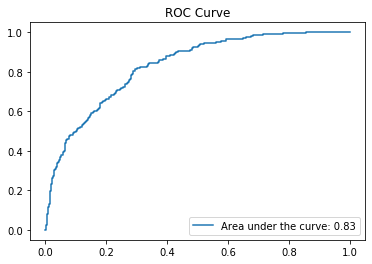

In [47]:
clfSyn = LogisticRegression(random_state=default_seed, max_iter=1000)
clfNoSyn = LogisticRegression(random_state=default_seed, class_weight={0:1,1:10}, max_iter=1000)
test_classifier_train_fold(x_train_syn, y_train_syn, clfSyn)
test_classifier_train_fold(x_train, y_train, clfNoSyn)

Los resultados indican que, cuando se utilizan datos sintéticos, la precisión mejora substancialmente, y se clasifican más empresas sanas correctamente. El precio a pagar es una mala detección de las empresas zombis, como indica el recall inferior.

Puede resultar de gran interés estudiar el porqué esta vez la precisión es tan alta. El modelo se puede explicar a través de los coeficientes de regresión y su significancia estadística. Esto se puede conseguir mediante la librería statsmodels, que permite obtener un resumen completo del modelo regresor.

In [48]:
def plot_logit_importance(x_train, y_train):
    # Crear el modelo
    logit_model = sm.Logit(y_train,x_train).fit()

    # Realizar las predicciones
    y_pred = logit_model.predict(x_test).apply(lambda x: 1 if x >= 0.5 else 0)

    # Obtener el resumen
    df = pd.DataFrame(logit_model.summary().tables[1])
    cols = df.iloc[0].apply(lambda x: str(x))
    df = df.rename(columns=cols)
    df = df.drop(df.index[0])
    df = df.set_index(df.columns[0])
    df['coefNew'] = df['coef'].apply(lambda x: float(str(x)))
    df = df.sort_values(by='coefNew',ascending=False)
    df = df[['coef','std err','z','P>|z|']]

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(df)
    return df

In [49]:
coef = plot_logit_importance(x_train_syn, y_train_syn)

Optimization terminated successfully.
         Current function value: 0.290503
         Iterations 9
                                       coef    std err          z   P>|z|
                                                                         
Endeudamiento                        2.7967      0.186     15.054   0.000
RelActivoCortoImpuestos_CAT          0.6967      0.055     12.566   0.000
RelActivoCortoDeutores               0.6606      0.163      4.048   0.000
EndeudamientoFinanciero              0.5240      0.051     10.182   0.000
PTT131                               0.4868      0.043     11.261   0.000
CategoriaRuralInt                    0.4656      0.086      5.443   0.000
ACL                                  0.4345      0.051      8.596   0.000
RelPasivoCortoProvisiones_CAT        0.4165      0.058      7.141   0.000
RelActivoCortoInventarios_CAT        0.3889      0.053      7.315   0.000
RelActivoLargoPropiedades_CAT        0.3770      0.036     10.456   0.000
NumEmplead

Los coeficientes que contribuyen positivamente a la regresión (acercan la instancia hacia zombi) son:

1. Endeudamiento: la variable con más significancia estadística y con el coeficiente positivo más alto. Para cada unidad de endeudamieto la probabilidad de ser zombi aumenta más que en cualquier otra variable.
2. Las variables secundarias que aumentan la probabilidad de ser zombi son el capital social (PTT131), una mayor proporción de activos por impuestos corrientes respecto al total de activo corriente (RelActivoCortoImpuestos_CAT), la misma proporción para las cuentas por cobrar (RelActivoCortoDeutores_CAT), un mayor endeudamiento financiero y estar en una zona más urbana.

Las variables que quitan puntos a ser zombi básicamente son las secciones y los departamentos, en mayor o menor medida. Esto se debe a la reducción masiva de instancias cuando una de estas variables toma el valor 1, ya que existen muchas categorías.

En conjunto, se pueden observar los coeficientes de regresión de las secciones y de los departamentos, para así determinar cuáles tienen más o menos influencia zombi.

* D (Suministros de electricidad y gas), F (Construcción), y H (Transporte y almacenamiento) son los tres sectores con menos concentración zombi. Tiene un coeficiente mucho más bajo que los demás sectores, y esto provoca que se rebaje la probabilidad de que una instancia de esos sectores sea zombi.
* G (Retail), C (Manufactura) y A (Agricultura). Son los tres primeros sectores con más concentración zombi.

Y para los departamentos:

* Risaralda, Norte de santander, Calda tienen poca concentración zombi.
* Bogotá, Antioquia y Bolívar tienen más concentración zombi en comparación con las anteriores.

Las otras variables tienen una influencia mucho menor en aumentar o disminuir las odds de clasificación, por lo que no se consideran relevantes. Además, algunas no tienen significancia estadística según el contraste realizado por la regresión.

Se evalúan en el conjunto de test los dos modelos, con y sin datos sintéticos.

Exactitud: 0.85
Precisión: 0.36
Recall: 0.42
F1 Score: 0.39
Matriz de confusión: 
          No zombi  Zombi
No zombi      2090    220
Zombi          169    122


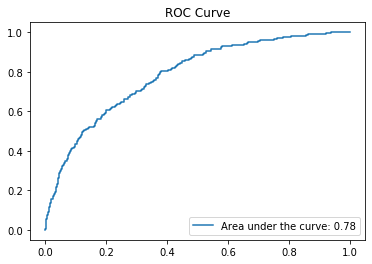

Exactitud: 0.63
Precisión: 0.21
Recall: 0.86
F1 Score: 0.34
Matriz de confusión: 
          No zombi  Zombi
No zombi      1375    935
Zombi           40    251


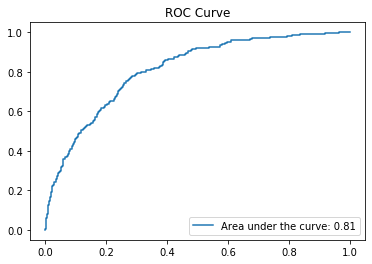

In [50]:
clfReg = LogisticRegression(random_state=default_seed, max_iter=1000, class_weight={0:1,1:10})
clfRegSyn = LogisticRegression(random_state=default_seed, max_iter=1000)

clfReg.fit(x_train, y_train)
clfRegSyn.fit(x_train_syn, y_train_syn)

# Con datos sintéticos
print_test_classifier(clfRegSyn, x_test, y_test, ['No zombi','Zombi'])
# Sin datos sintéticos
print_test_classifier(clfReg, x_test, y_test, ['No zombi','Zombi'])

El clasificador entrenado sin datos sintéticos tiende a clasificar más empresas zombis correctamente, pero paga el precio de la baja precisión.

El clasificador que utiliza datos sintéticos no consigue buenos resultados. Aunque captura algunas empresas zombis, su recall y precisión son muy bajos. Parece que esté relajando la línea para detectar zombis respecto al otro clasificador, y esto provoca que no se obtengan tantos falsos positivos, pero aumenten los falsos negativos. 

En todo caso, se prefiere un buen recall al clasificador entrenado con datos sintéticos. Resulta más interesante describir todas aquellas características que presentan las empresas zombis, aunque algunas sanas las compartan.

Por último se evalúan rápidamente los resultados al intentar clasificar utilizando los datos básicos únicamente. Se espera que los resultados sean muy similares a los conseguidos anteriormente.

In [51]:
clfBas = LogisticRegression(random_state=default_seed, max_iter=1000, class_weight={0:1,1:10})
KFoldCV_Results(5, clfBas, x_train_bas, y_train_bas)

Fold results:
-----------------------
Exactitud: 0.40
Recall: 0.80
Precisión: 0.15
F1 Score: 0.25
-----------------------
Fold results:
-----------------------
Exactitud: 0.38
Recall: 0.85
Precisión: 0.15
F1 Score: 0.26
-----------------------
Fold results:
-----------------------
Exactitud: 0.39
Recall: 0.78
Precisión: 0.15
F1 Score: 0.25
-----------------------
Fold results:
-----------------------
Exactitud: 0.40
Recall: 0.78
Precisión: 0.16
F1 Score: 0.26
-----------------------
Fold results:
-----------------------
Exactitud: 0.38
Recall: 0.84
Precisión: 0.14
F1 Score: 0.25
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.39
Recall: 0.81
Precisión: 0.15
F1 Score: 0.25


Efectivamente no hay diferencias significativas respecto a los árboles de decisión, por lo que las conclusiones son las mismas.

### Máquinas de vectores de soporte
Las máquinas de vectores de soporte o SVM, son clasificadores que crean un hiperplano separador en un espacio de grandes dimensiones que separa las clases de la variable objetivo.

Este algoritmo se considera de caja negra, es decir, que no resulta trivial interpretar las decisiones que se toman (salvo cuando el número de dimensiones es bajo). Aún así, existen maneras de conseguir una cierta interpretabilidad.

Antes de empezar, se puede realizar una selección de características. Modelos anteriores han demostrado que algunas características aportan poco o nada en los procesos de decisión. Eliminar las características redundantes puede ser de gran interés de cara a la computación de los algoritmos de caja negra, que suelen necesitar muchos recursos.

Así pues, es posible cruzar los datos de la selección de atributos en el proceso de etiquetado, con los modelos de árboles de decisión y regresión logística, para descartar aquellos atributos irrelevantes.

Aquellas características que no tengan significancia estadística en la regresión logística serán descartados.

In [52]:
coef['P_float'] = coef['P>|z|'].apply(lambda x: float(str(x)))
varsEliminar = [str(s) for s in coef[coef['P_float'] >= 0.05].index.tolist()]

# Eliminar las columnas y mostrarlas
x_train_sel = x_train.drop(varsEliminar, axis=1)
x_test_sel = x_test.drop(varsEliminar, axis=1)

print(x_train_sel.columns)

Index(['NumEmpleadosLog', 'ACL', 'PTT131', 'RAIE', 'VAR_REL_AC', 'VAR_REL_ACC',
       'VAR_REL_ACL', 'VAR_REL_PT', 'VAR_REL_RAIE', 'ApalancCorto',
       'VAR_ABS_ApalancCorto', 'ApalancLargo', 'Endeudamiento',
       'EndeudamientoFinanciero', 'RelActivoCortoDeutores',
       'RelActivoCortoInventarios_CAT', 'RelActivoCortoImpuestos_CAT',
       'RelActivoLargoPropiedades_CAT', 'RelActivoLargoImpuestos_CAT',
       'RelActivoLargoIntangibles_CAT', 'RelPasivoCortoProvisiones_CAT',
       'RelPasivoCortoOtros_CAT', 'RelPasivoLargoOtros_CAT', 'PTT237_CAT',
       'PTT133_CAT', 'VAR_REL_RAGE60_CAT', 'TamanyoInt', 'CategoriaRuralInt',
       'SA', 'SAS', 'SociedadOtros', 'OtrosDepartamentos', 'antioquia',
       'atlantico', 'bogota', 'bolivar', 'caldas', 'cundinamarca', 'magdalena',
       'meta', 'norte santander', 'risaralda', 'santander', 'tolima', 'valle',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S'],
      dtype='object')


Una vez se ha reducido el tamaño de las características, se pone a prueba el SVM, la hipótesis es que las métricas sigan siendo similares a los modelos anteriores, sin un perjurio significativo en el rendimento del modelo.

In [53]:
# Crear el modelo
clf = SVC(random_state=default_seed, class_weight={0:1,1:10})
# Kfold cross validation con 5 folds
printKFoldResults(kfold_crossvalidation(5, clf, x_train_sel, y_train))

Fold results:
-----------------------
Exactitud: 0.65
Recall: 0.83
Precisión: 0.25
F1 Score: 0.39
-----------------------
Fold results:
-----------------------
Exactitud: 0.65
Recall: 0.86
Precisión: 0.25
F1 Score: 0.38
-----------------------
Fold results:
-----------------------
Exactitud: 0.67
Recall: 0.87
Precisión: 0.27
F1 Score: 0.41
-----------------------
Fold results:
-----------------------
Exactitud: 0.66
Recall: 0.87
Precisión: 0.25
F1 Score: 0.39
-----------------------
Fold results:
-----------------------
Exactitud: 0.65
Recall: 0.84
Precisión: 0.24
F1 Score: 0.37
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.66
Recall: 0.85
Precisión: 0.25
F1 Score: 0.39


Los resultados son muy similares a la regresión logística en todas las métricas, por lo que la selección de variables es satisfactoria. La precisión y el recall siguen la misma línea anterior, por lo que se espera que este algoritmo no sea la clave para arreglar el problema de los falsos positivos.

Este modelo servirá para sentar las bases de la interpretabilidad, por lo que no se considera su ajuste perfecto. Es muy intensivo computacionalmente realizar un grid search para SVM, y el modelo ya rinde más o menos a los límites esperados dada la naturaleza de los datos.

Se evalúa SVM bajo el conjunto de test, donde se espera que rinda similar a la validación cruzada. Esta vez se fuerza a que el estimador sea una función de probabilidad, para poder dibujar la curva ROC.

In [54]:
# Se utiliza probability=True para poder sacar el ROC del clasificador
clfSvc = SVC(random_state=default_seed, C=1, class_weight={0:1,1:10}, probability=True)
clfSvc.fit(x_train_sel,y_train)
pass

Exactitud: 0.63
Precisión: 0.21
Recall: 0.87
F1 Score: 0.34
Matriz de confusión: 
          No zombi  Zombi
No zombi      1374    936
Zombi           39    252


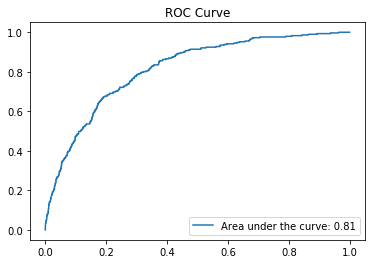

In [55]:
print_test_classifier(clfSvc, x_test_sel, y_test, ['No zombi','Zombi'])

El recall es bastante bueno, pero la precisión como siempre no llega a los números esperados. Todo esto respalda la teoría de las variables ocultas.

En resumen, SVC también aprende a discriminar las empresas zombis de las no zombis, pero no puede capturar las características ocultas. De momento, es el clasificador con mejor rendimiento en test.

### Interpretabilidad de los modelos
La interpretabilidad de un modelo de aprendizaje automático es su grado de decisiones explicables.

En función del tipo de modelo concreto, la interpretabilidad puede ser mayor o menor. En este mismo cuaderno, se han puesto a prueba principalmente modelos de caja blanca, con alta interpretabilidad, dónde las decisiones de clasificación son triviales de conocer.

Por otra parte, los modelos de caja negra tienen baja interpretabilidad, ya que las decisiones que toman son en función de muchos parámetros, imposibles de comprender para un humano cualquiera. Los modelos de caja negra comúnmente rinden mejor que los de caja blanca, ya que su complejidad es mayor, y por lo tanto pueden capturar más información acerca del modelo real que se esconde en los datos.

Existen técnicas que permiten interpretar las decisiones que toman los modelos de caja negra. Estas técnicas se pueden clasificar en dos grupos, principalmente. [Fuente](https://christophm.github.io/interpretable-ml-book/scope-of-interpretability.html).

* Análisis global: intenta describir el modelo de forma general, tratando todos los datos a la vez, y bajo un subconjunto de características.
* Análisis local: describe los mecanismos que empujan a una sola instancia o a un grupo reducido de instancias a ser clasificado de una forma u otra.

Para el análisis global, se disponen de diversas técnicas. Algunas de las más simples son:

1. [Importancia de permutaciones](https://christophm.github.io/interpretable-ml-book/feature-importance.html): permutar valores en columnas individuales una a la vez, y después evaluar las predicciones. La estadística del error denota si la columna tiene importancia o no en el modelo.
2. [Partial Dependence Plots (PDP)](https://blogs.sas.com/content/subconsciousmusings/2018/06/12/interpret-model-predictions-with-partial-dependence-and-individual-conditional-expectation-plots/): visualizaciones que proyectan el cambio en la variable dependiente en función de una o varias dependientes. Para dibujar la gráfica, se calcula la media de las predicciones a través de todo el dataset mientras se cambia el valor de la variable de estudio, dentro de un rango de valores.
3. Individual Conditional Expectation (ICE): proyectan la evolución de la variable objetivo en función de una variable independiente. Difieren de los PDP, ya que solo proyectan una línea para cada instancia. Su interpretación es muy similar a los PDP.

En otros métodos más avanzados, encontramos por ejemplo los [Shap values](https://christophm.github.io/interpretable-ml-book/shap.html). Estos utilizan los valores de Shapley (basados en la teoría de juegos), que calculan las contribuciones de cada característica del dataset en la predicción final. Este método permite interpretar el modelo basándose en aquellas características que más aportan a las predicciones. Sin embargo, calcular los valores shapley es computacionalmente muy costoso, y no se puede llevar a cabo con los recursos de este proyecto, por lo que se descarta su uso.

En primer lugar se pone a prueba la **importancia por permutación**. Este algoritmo realiza varias permutaciones sobre variables de forma individual, y luego calcula las diferencias en las métricas de clasificación antes y después de permutar.

Su salida es la media de importancia de todas las permutaciones calculadas y su desviación típica. Si esta media es positiva y grande, indica que esa permutar esa característica tiende a incrementar el error. Cuando más baja es, menos cambia el error al permutar la variable. Si es negativa, simplemente indica que el error ha mejorado, y esto puede ser un indicativo de que la variable también es importante.

Se calcula la importancia de las permutaciones utilizando la librería eli5.

In [56]:
perm = PermutationImportance(clfSvc, random_state=default_seed).fit(x_test_sel,y_test)

In [ ]:
# No se muestra por no ser exportable
eli5.explain_weights(perm,feature_names=x_test_sel.columns.tolist(), target_names=['No zombi','Zombi'], top=len(x_test_sel.columns))

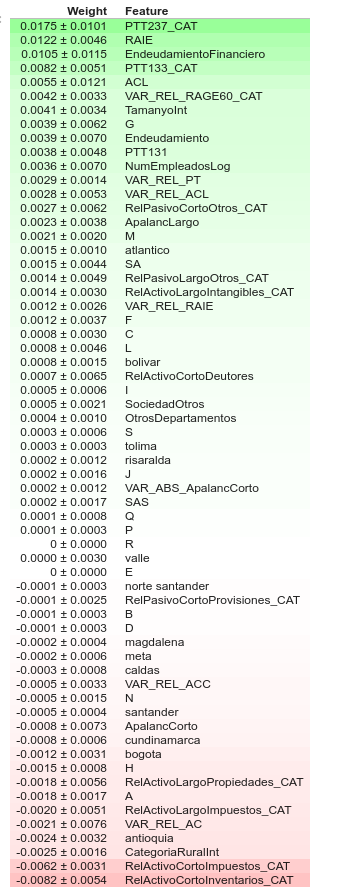

In [93]:
from IPython.display import Image
# Mostrar una imagen
Image(filename='assets/Permutation_SVM.PNG')

Los resultados siguen la línea vista hasta el momento. Datos financieros sobrepasan con creces la importancia de los datos básicos de empresa. Las variables con más importancia son los fondos propios, los ingresos operacionales y el endeudamiento financiero.

En segundo lugar destacan otras variables financieras como las reservas (PTT133), las relaciones entre el activo corto y los impuestos e inventarios (RelActivoCortoImpuestos/Inventarios_CAT) y el activo a largo.

Las otras variables tienen muy poca importancia en comparación, lo que significa que los resultados no se alteran cuando se permuta dicha característica.

A continuación se evalúan los PDP para los indicadores financieros de las empresas. La evaluación se realiza sobre una muestra de test, ya que utilizar todo el conjunto puede ser computacionalmente costoso.

In [58]:
def internal_plot_partial_dependence(clf, x, columns, kind='average'):
    # Obtener los indices de las columnas
    columns = x.columns.tolist()
    columns_index = [x.columns.get_loc(i) for i in columns]
    # Realizar el plot
    height = len(columns)/3 * 3.5
    fig,ax = plt.subplots(figsize=(16,height))
    plot_partial_dependence(clf, features=columns_index, X=x, \
                            feature_names=x.columns.tolist(), grid_resolution=10, ax=ax, kind=kind, random_state=default_seed)
    plt.show()
    
def PDP(clf, x, columns):
    internal_plot_partial_dependence(clf, x, columns)

def ICE(clf, x, columns):
    internal_plot_partial_dependence(clf, x, columns, 'both')

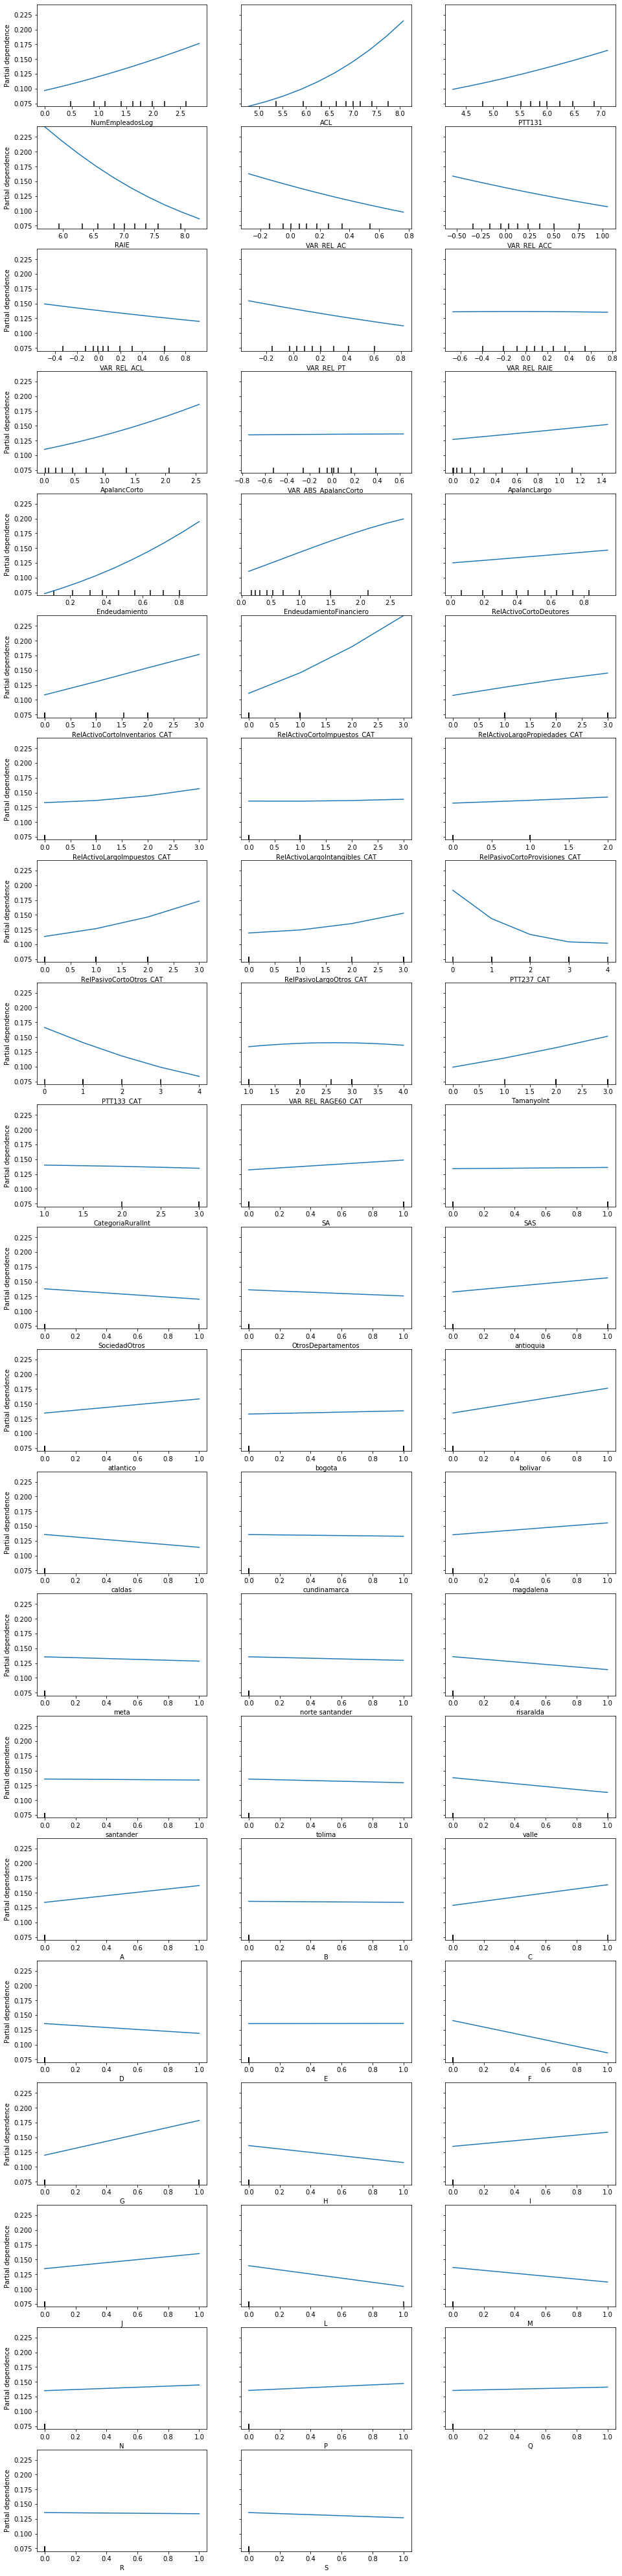

In [59]:
PDP(clfSvc, x_test_sel.sample(500,random_state=default_seed), x_test_sel.columns.tolist())

Se recuerda que todas las características explicadas se basan en el clasificador. Solo es una aproximación a la realidad, ya que el modelo no es para nada perfecto. Solo permite explicar algunas propiedades de un modelo que tiene un error determinado.

Dicho esto, en estas visualizaciones se puede observar la influencia directa que tiene una variable sobre la predicción final. Cuando la función es creciente significa que a mayor valor de la variable, mayor probabilidad de ser la instancia etiquetada como zombi, y viceversa. Aquellas variables sin una pendiente pronunciada tienen poca o ninguna influencia en las predicciones.

Destacan, como variables financieras que más influyen a predecir la empresa como zombi:

* El activo a largo (ACL).
* El endeudamiento.
* El endeudamiento financiero.
* La relación entre el activo a corto de los impuestos corrientes y el activo corriente (RelActivocortoImpuestos_CAT)

Por la otra parte, las variables financieras que contribuyen a sanear una empresa son:

* Los ingresos operacionales (RAIE).
* Las reservas (PTT133_CAT). Cuando una empresa no tiene reservas, tiene más tendencia zombi.
* Las ganancias acumuladas (PTT237_CAT). A mayor número de ganancias, menor tendencia zombi. Destacan negativamente aquellas empresas con ganancias acumuladas negativas.

Estas variables son las que tenían más peso en las permutaciones. Mediante los ACL se puede determinar el signo de su contribución.

Asimismo, a mayor tamaño de la empresa y/o número de empleados también influyen a predecir la empresa como zombi.

Respecto a los sectores:

1. Los sectores que más atraen a zombis son: A (Agricultura), C (Manufactura), G (Comercio) e I (Hostelería).
2. Sectores con menos inclinación a acumular zombis: D (Suministros), F (Construcción), H (Transportes) y L (Inmobiliario)

Las variaciones en los indicadores (VAR_REL...) denotan que a mayor variación (o incremento) en los activos y patrimonio, menor zombicidad. Es decir, las empresas que presentan crecimiento en activos o patrimonio tienden a ser menos zombis. Aunque la diferencia entre los dos extremos no es demasiado notable.

Respecto a los departamentos, destacan Antioquia y Bolívar como aquellos con más inclinación a acumular zombis, mientras que Valle y Risaralda, por ejemplo, no aumentan la probabilidad de ser zombi para una empresa.

Por la otra banda, también se pueden proyectar los ICE de cada variable. Estos dibujan una línea para cada instancia.

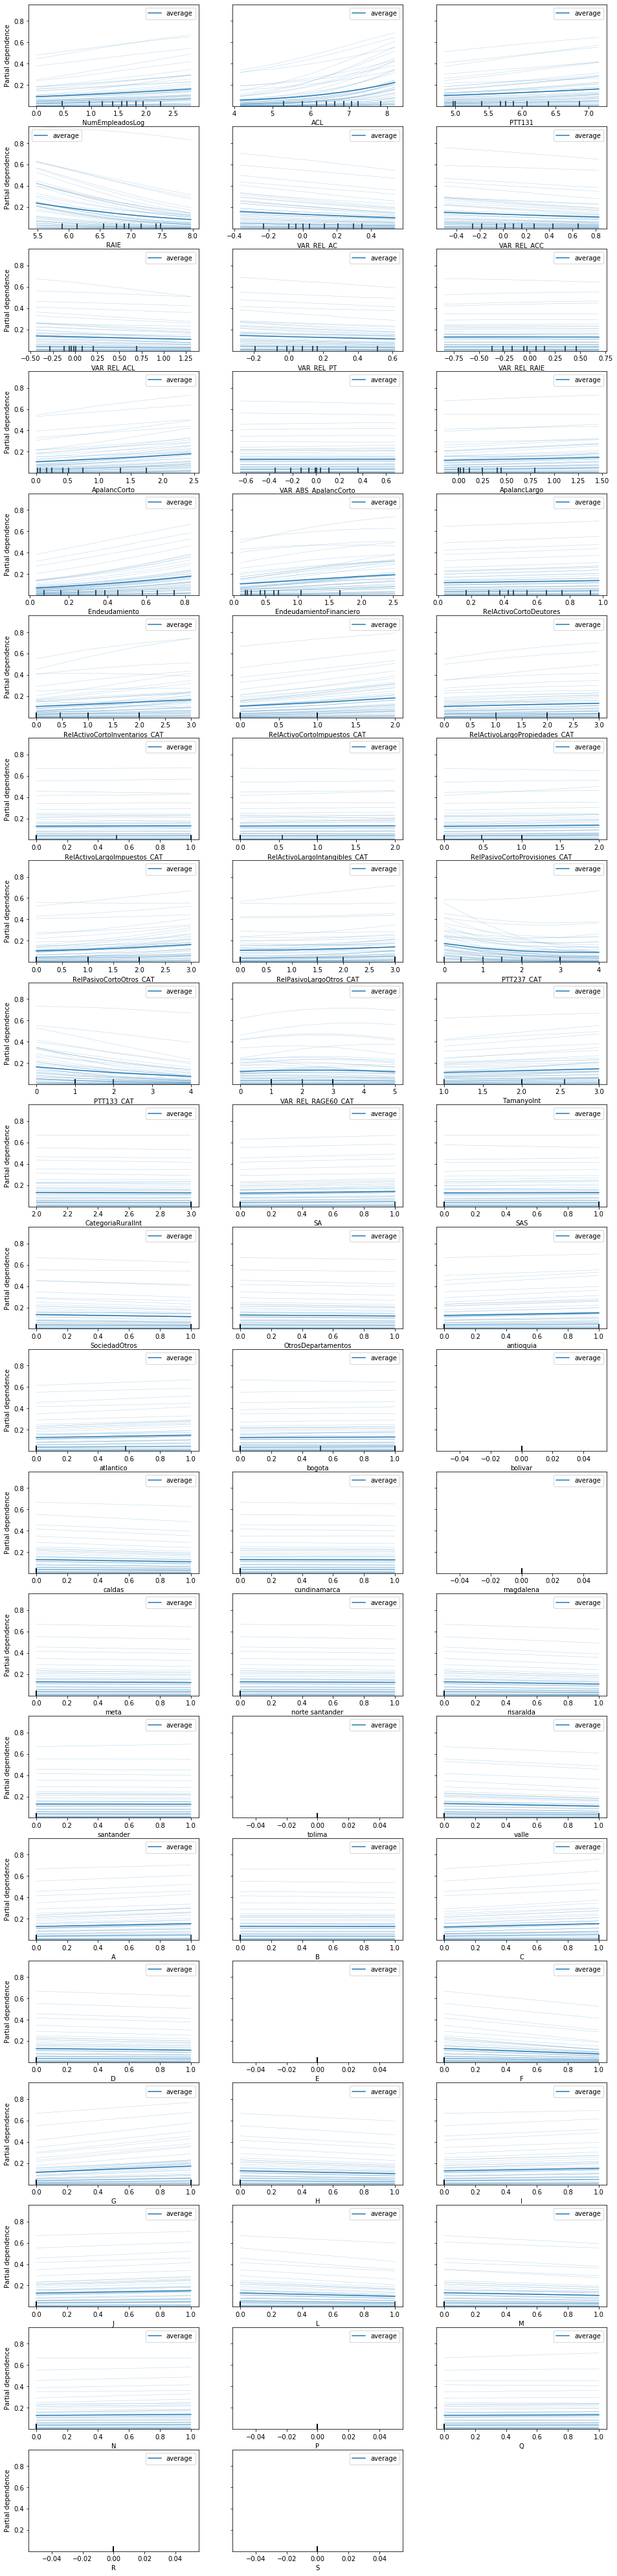

In [60]:
ICE(clfSvc, x_test_sel.sample(50, random_state=default_seed), x_test_sel.columns.tolist())

Los ICE son un complemento para observar la tendencia individual de los PDP, pero en este caso no aportan mucha más información.

A continuación se pone a prueba la **interpretabilidad local**. Este grupo de técnicas explican las predicciones realizadas para una instancia en concreto.

LIME (Local Interpretable Model-agnostic Explainations) es una técnica de interpretabilidad local que consiste en:

1. Para una instancia concreta y un modelo de caja negra, realizar predicciones realizando ligeras perturbaciones en las características de la instancia.
2. Se entrena un modelo subrogado de caja blanca con las instancias perturbadas y sus predicciones, balanceado según la distancia de las perturbaciones hacia la instancia original.
3. A partir del modelo subrogado, se explican las características que más afectan a las predicciones.

Esta técnica permite obtener una explicación de qué variables influyen más de manera **local** a una instancia en concreto, pero no sirven para explicar el modelo de manera global.

La librería lime permite obtener la importancia de las variables según instancias concretas. Se eligen 2 ejemplos para cada tipo de clasificación (TP, FP, FN, TN), y visualiza el resultado de aplicar LIME sobre ellas.

In [90]:
import lime
from lime import lime_tabular

# Crear el modelo explicador
def create_explainer(x_train, class_names):
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(x_train),
        feature_names=x_train.columns,
        class_names=class_names,
        random_state=default_seed,
        mode='classification'
    )
    return explainer

# Obtener un número reducido de FP, TP, FN, TN según el modelo.
def getLocalInstances(clf,x_test, y_test):
    y_pred = clf.predict(x_test)
    y_test_np = y_test.to_numpy().reshape(-1,1)
    y_pred_np = y_pred.reshape(-1,1)
    TP = (y_test_np == 1) & (y_pred_np == 1)
    FP = (y_test_np == 0) & (y_pred_np == 1)
    TN = (y_test_np == 0) & (y_pred_np == 0)
    FN = (y_test_np == 1) & (y_pred_np == 0)
    
    ret = {'TP':TP,'FP':FP,'TN':TN, 'FN':FN }
    rangeI = range(0,2)
    return [(key, x_test.iloc[elem].iloc[rangeI]) for key, elem in ret.items()]
   
    
# Explicar las instancias mediante la visualización
def explainInstances(clf, x_train, x_test, y_test, class_names):
    explainer = create_explainer(x_train, class_names)
    for name, instances in getLocalInstances(clf, x_test, y_test):
        print("Explaining: {0}".format(name))
        for i in range(2):
            exp = explainer.explain_instance(
                data_row=instances.iloc[i], 
                predict_fn=clf.predict_proba
            )
            exp.show_in_notebook(show_table=True)


In [ ]:
# No se muestra el output por no ser exportable
explainInstances(clfSvc, x_train_sel, x_test_sel, y_test, ['No zombi','Zombi'])

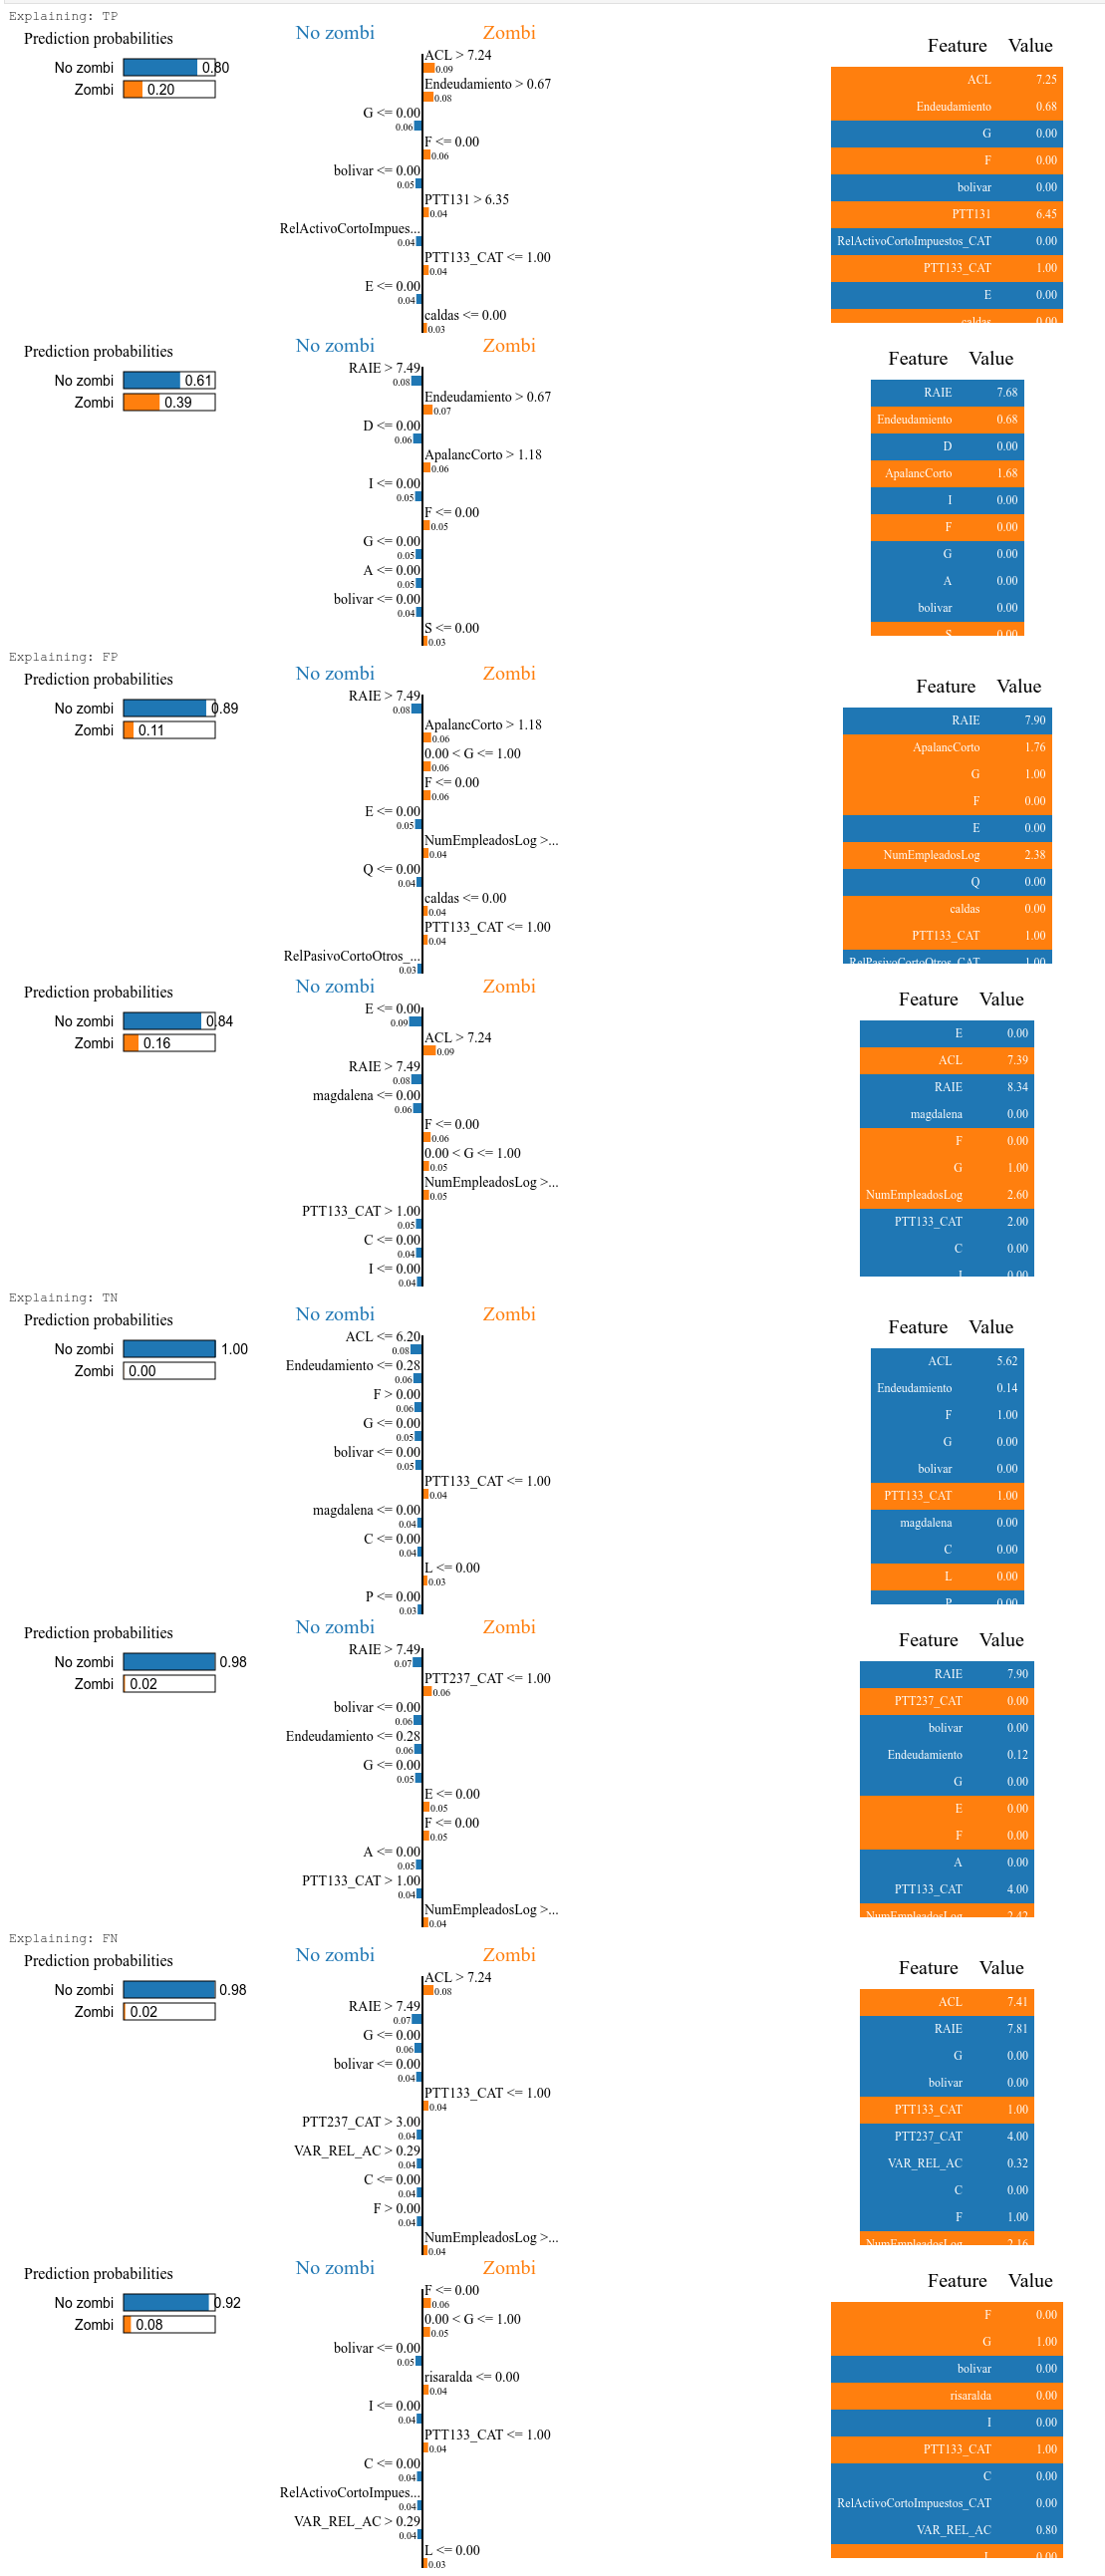

In [92]:
from IPython.display import Image
# Mostrar una imagen
Image(filename='assets/LIME_SVM.PNG')

Se remarca que las probabilidades no están escaladas según los pesos de penalización en las gráficas, por lo que es necesario multiplicar por 10 la probabilidad zombi para así obtener la clasificación real de la instancia. Al menos en este clasificador.

A través de estas visualizaciones se puede entender mejor el origen de los falsos positivos. En ambos casos (Explaining: FP), el endeudamiento juega un papel crucial en la predicción de la empresa como zombi. Como se puede ver, la no pertinencia a ciertos sectores baja la probabilidad de ser zombi (comercio, G, por ejemplo), y la no pertinencia a otros sectores la sube (como F, construcción). Los sectores equilibran la balanza hacia un sentido u otro, como se puede observar.

Respecto a los falsos positivos, son causados por un alto nivel de empleados y activos a largo plazo, o bien un alto nivel de apalancamiento. Se puede apreciar que son declarados positivos en zombis por poco margen, a diferencia de los verdaderos positivos, que tienen un margen más alto.

Los verdaderos negativos explican como el sector de la construcción efectivamente resta puntos a ser zombi, y un bajo nivel de endeudamiento también contribuye, así como un alto nivel de ingresos.

En general, los falsos negativos han sido provocados por bajos niveles de endeudamiento y un alto nivel de ingresos operacionales, así como un incremento en los activos o el patrimonio a el alza. Estos síntomas, que deberían ser zombis, engaña a los modelos para clasificarlos como FN.

## Redes neuronales
Las redes neuronales son el modelo de caja negra por excelencia. Su gran potencia queda eclipsada por su baja interpretabilidad.

Estos algoritmos utilizan un conjunto de capas de neuronas, las cuales contienen la capa de entrada y la de salida. Cada variable independiente se conecta con cada neurona de la capa de entrada, y estas propagan una señal hacia la capa de salida, pasando por todas las capas intermedias.

La capa de salida es la responsable de proporcionar un output que sirva para clasificar la instancia como una clase u otra.

Las neuronas tienen un peso concreto y una función de activación. El peso es la importancia que dan a cada entrada suya, y determina qué entradas tienen mayor importancia para activar la neurona.

Las redes neuronales se entrenan utilizando la propagación hacia atrás, dónde los datos de entrenamiento son propagados hacia adelante en primera instancia, solo para calcular su error y propagarlo hacia atrás, así ajustando los pesos de las neuronas de la red.

Existen multitud de parámetros en una red neuronal. Estos son en gran parte cruciales para determinar el éxito de la fase de entrenamiento. Con un buen ajuste, la propagación hacia atrás realiza un ajuste de los pesos ideal para mejorar la precisión del modelo hasta el punto deseado.

En primer lugar, se separa el conjunto de entrenamiento original en dos, ya que para entrenar la red se requiere de un conjunto de test. Cuando la red esté entrenada entonces ya se podrá validar el modelo en el conjunto de test/validación original.

Esta vez, se prefiere recurrir al downsampling para solucionar el problema del desequilibrio de clases. Pruebas hechas con distintos parámetros han denotado que el aprendizaje más pausado y estable se consigue sin utilizar pesos de penalización para los errores de clasificación según las clases.

In [71]:
# Crear una matriz para la variable objetivo
y = y_train.to_numpy().reshape(-1,1)
# Partir el conjunt ode entrenamiento dataset en train y test al 30%
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(x_train_sel,y,test_size=0.1,random_state=default_seed)

# Reducir las empresas sanas en train
x_train_nn, y_train_nn = undersample_train(x_train_nn, y_train_nn)
y_train_nn = y_train_nn.reshape(-1,1)

Las redes neuronales requieren normalización para evitar el sasgo hacia las variables que toman valores más grandes que otras. Se implementa una normalización MinMax para escalar los datos hacia el rango {0,1}. La normalizción se ajusta a toda la selección de datos original.

In [72]:
# Escalar los datos en el rango {0,1}
sc = MinMaxScaler()
sc.fit(selection.drop(varsEliminar, axis=1))
x_train_nn_norm = sc.transform(x_train_nn)
x_test_nn_norm = sc.transform(x_test_nn)

In [73]:
# Observar la primera instancia
x_train_nn_norm[0]

array([0.63649057, 0.75350148, 0.6082784 , 0.75924992, 0.70351538,
       0.24521172, 0.41747496, 0.53572731, 0.4184616 , 0.77187127,
       0.43698962, 0.56196005, 0.4732937 , 0.13020877, 0.07742942,
       0.66666667, 0.33333333, 1.        , 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 1.        , 1.        , 0.        ,
       0.6       , 1.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

Una vez se tienen los datos preparados, ya se puede entrenar el modelo. Los parámetros del modelo se han ajustado de forma empírica a través de la observación de la evolución del entrenamiento y de los resultados. En resumen, la red neuronal debe tener las siguientes características y restricciones:

* El dataset no está balanceado, por lo que se requiere especificar el parámetro "class_weight" en el modelo. Este parámetro penaliza el error en cada clase según la magnitud indicada. En este caso, interesa una penalización de 10 cuando se entrena una instancia zombi.
* La función de pérdida es "binary_crossentropy", esta función es la preferible cuando se trata de clasificación binaria. La capa de salida debe consistir de una neurona con función de activación "sigmoide", que proyecta la característica S en el plano. Esta función es ideal para la clasificación binaria.
* La arquitectura tiene que ser la adecuada para el problema a resolver. La capa inicial debe tener un gran número de neuronas ya que el número de variables de entrada es muy grande, a medida que se avanza hacia las últimas capas se debe ir reduciendo el número de neuronas para que la red generalice mejor.
* La métrica a evaluar en cada época debe ser la precisión binaria, al tratarse de un problema de clasificación binario.
* Se utilizan capas de dropout para evitar el sobreajuste a los datos de entrenamiento.
* El learning rate debe ser muy bajo para evitar saltos grandes entre iteraciones de entrenamiento. De esta manera se consigue un entrenamiento estable y progresivo tanto en train como en test.

El modelo se encapsula en la clase KerasRegressor, que es un wrapper que acepta las operaciones de los modelos estándard de sklearn. Esto resulta útil para calcular las métricas e interpretar el modelo a posteriori.

In [74]:
input_size = len(x_train_nn_norm[0])
output_size = len(y_train_nn[0])

def get_model():
    return Sequential([
        Dense(100, activation='relu', input_shape=(input_size,)),
        Dropout(0.4),
        Dense(70, activation='relu'),
        Dropout(0.4),
        Dense(20, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def visualize_model(hist,model):
    fig = plt.figure(figsize=(12, 4))
    
    # Evolución de la precisión en train y test
    plt.subplot(1,2,1)
    plt.plot(hist.history['binary_accuracy'])
    plt.plot(hist.history['val_binary_accuracy'])
    plt.title('{} accuracy'.format(model))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Evolución de la pérdida en train y test
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('{} loss'.format(model))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower left')
    fig.tight_layout()
    plt.show()
    
def regressor_model():
    model_wr = get_model()
    model_wr.compile(optimizer=Adam(0.00001),loss='binary_crossentropy',metrics=['binary_accuracy'])
    return model_wr


In [75]:
# Crear el modelo
estimator = KerasRegressor(build_fn=regressor_model, nb_epoch=100, batch_size=2, verbose=False)
# Ajustar el modelo
np.random.seed(default_seed)
history = estimator.fit(x_train_nn_norm, y_train_nn,validation_data=(x_test_nn_norm,y_test_nn), verbose=1, epochs=100, batch_size=2)

Epoch 1/100
1213/1213 [==============================] - 3s 2ms/step - loss: 0.6994 - binary_accuracy: 0.4919 - val_loss: 0.6537 - val_binary_accuracy: 0.8857
Epoch 2/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6953 - binary_accuracy: 0.4853 - val_loss: 0.6565 - val_binary_accuracy: 0.8857
Epoch 3/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6918 - binary_accuracy: 0.5259 - val_loss: 0.6627 - val_binary_accuracy: 0.8809
Epoch 4/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6975 - binary_accuracy: 0.4848 - val_loss: 0.6660 - val_binary_accuracy: 0.8751
Epoch 5/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6927 - binary_accuracy: 0.5185 - val_loss: 0.6697 - val_binary_accuracy: 0.8713
Epoch 6/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6940 - binary_accuracy: 0.5033 - val_loss: 0.6728 - val_binary_accuracy: 0.8588
Epoch 7/100
1213/1213 [=======================

1213/1213 [==============================] - 2s 2ms/step - loss: 0.6561 - binary_accuracy: 0.6411 - val_loss: 0.6308 - val_binary_accuracy: 0.6897
Epoch 53/100
1213/1213 [==============================] - 2s 1ms/step - loss: 0.6542 - binary_accuracy: 0.6475 - val_loss: 0.6291 - val_binary_accuracy: 0.6888
Epoch 54/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6531 - binary_accuracy: 0.6395 - val_loss: 0.6325 - val_binary_accuracy: 0.6763
Epoch 55/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6499 - binary_accuracy: 0.6494 - val_loss: 0.6289 - val_binary_accuracy: 0.6782
Epoch 56/100
1213/1213 [==============================] - 2s 2ms/step - loss: 0.6457 - binary_accuracy: 0.6544 - val_loss: 0.6225 - val_binary_accuracy: 0.6907
Epoch 57/100
1213/1213 [==============================] - 2s 1ms/step - loss: 0.6586 - binary_accuracy: 0.6220 - val_loss: 0.6195 - val_binary_accuracy: 0.6936
Epoch 58/100
1213/1213 [=============================

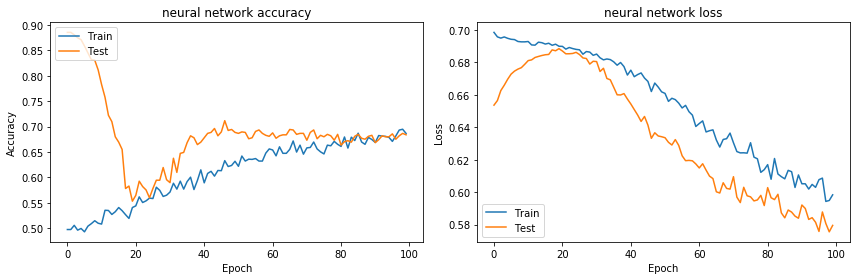

In [76]:
# Evolución del modelo
visualize_model(history,"neural network")

Se puede observar como el modelo evoluciona positivamente, pero ya no se espera que siga aumentando más según la proyección del conjunto de test.

Los resultados en test son mayores que en train, por lo que la red generaliza correctamente. Se procede a evaluar los resultados bajo el conjunto de validación (test original).

In [77]:
# Imprime los resultados de un clasificador
def print_test_classifier_nn(clf, x_test, y_test, classes):
    print_test_classifier(clf, x_test, y_test, classes, skip_roc=True, class_func=lambda x,y: np.round(x.predict(y)))
    
    
print_test_classifier_nn(estimator,sc.transform(x_test_sel), y_test, ['No zombi','Zombi'])

Exactitud: 0.65
Precisión: 0.21
Recall: 0.79
F1 Score: 0.34
Matriz de confusión: 
          No zombi  Zombi
No zombi      1463    847
Zombi           60    231


Sin duda los resultados son los mismos que de costumbre. La red ha aprendido a diferenciar a las empresas zombis pero a costa del sacrificio de clasificar incorrectamente algunas sanas. Para entender mejor las decisiones que toma se debe recurrir a los métodos de interpretabilidad del modelo ya explicados con anterioridad.

In [78]:
# Importancia de permutaciones
perm = PermutationImportance(estimator, random_state=1).fit(sc.transform(x_test_sel),y_test)

In [ ]:
# No se puede exportar, se guarda como imagen y se muestra luego
eli5.explain_weights(perm,feature_names=x_test_sel.columns.tolist(), target_names=['No zombi','Zombi'], top=len(x_test_sel.columns))

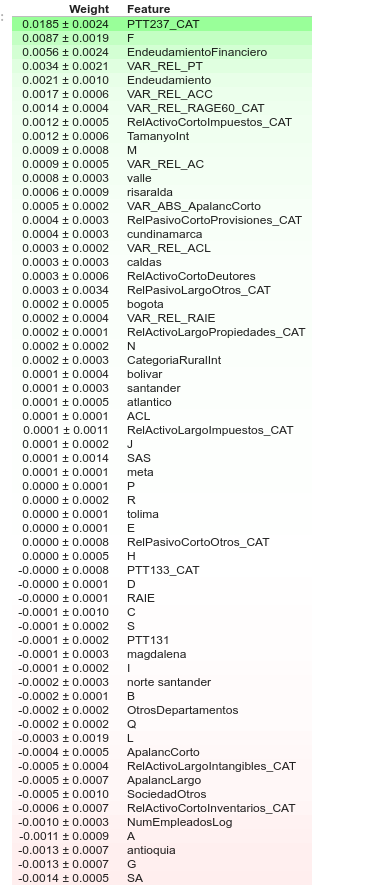

In [94]:
from IPython.display import Image
# Mostrar una imagen
Image(filename='assets/Permutation_NN.PNG')

La principal novedad respecto a la importancia de las características calculada anteriormente es que la red neuronal da mucha importancia a F (Construcción). Seguramente clasifique en gran medida como sanas las empresas del sector de la construcción. El algoritmo SVM no resolvía a F como característica tan importante.

Respecto a las otras variables, el endeudamiento y el endeudamiento financiero se encuentran muy arriba, como era de esperar. Las ganancias acumuladas siguen siendo la variable más importante.

Esta vez no existen variables que incrementen el rendimiento del modelo al ser permutadas, como curiosidad (esto se atribuye a la aleatoriedad de las permutaciones).

También se considera inspeccionar los PDP generador por la red neuronal. Esta vez se tiene que utilizar una librería externa debido a motivos de compatibilidad.

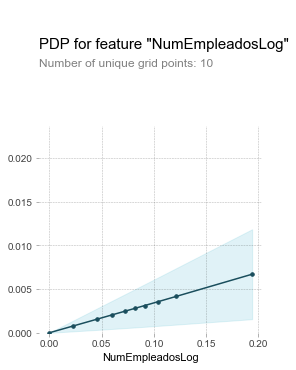

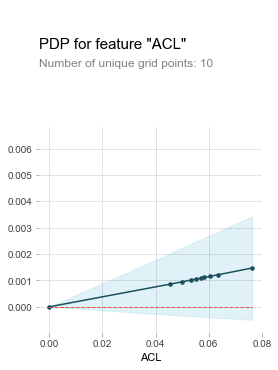

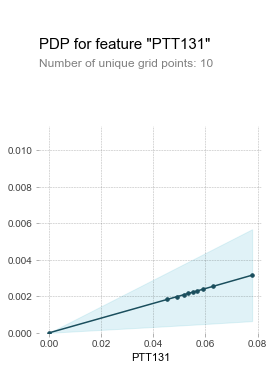

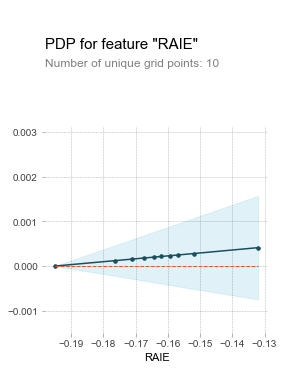

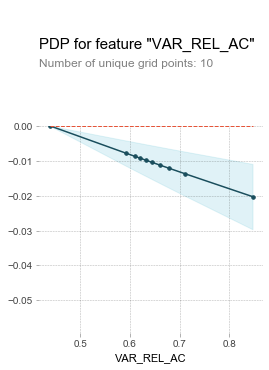

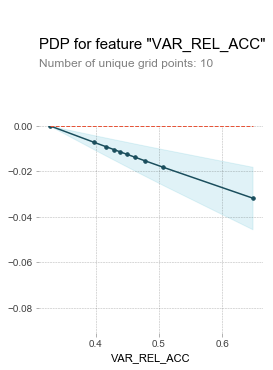

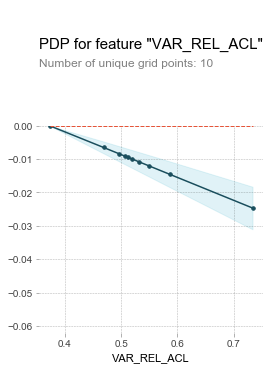

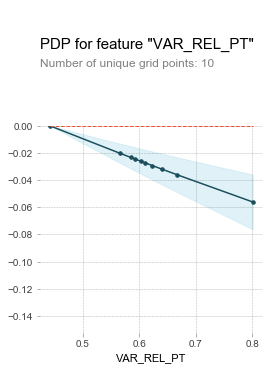

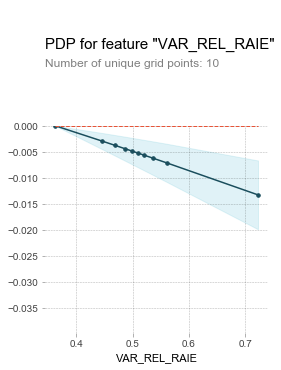

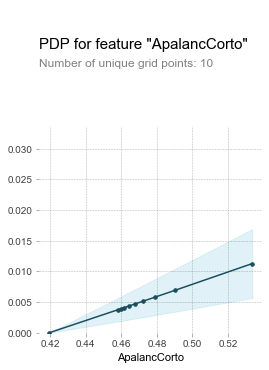

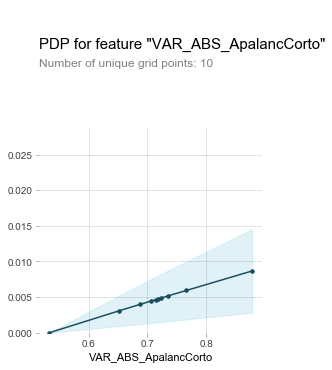

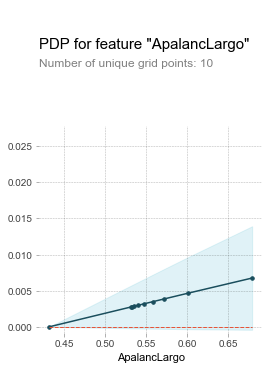

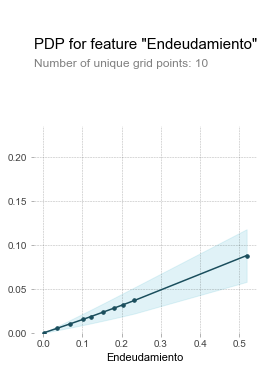

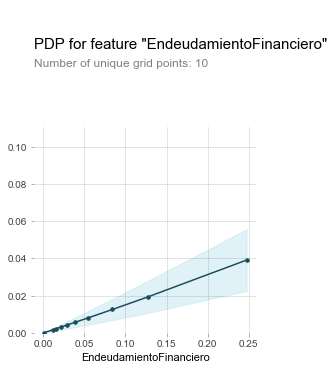

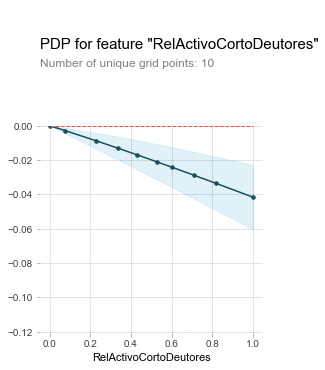

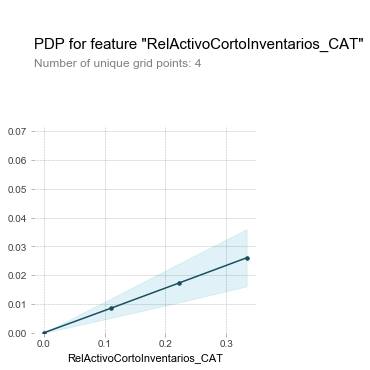

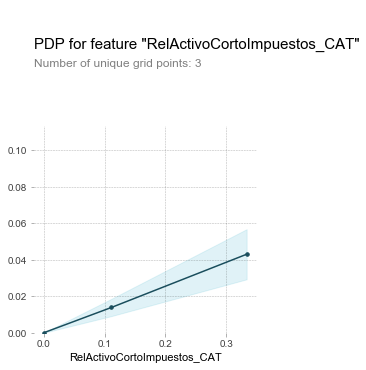

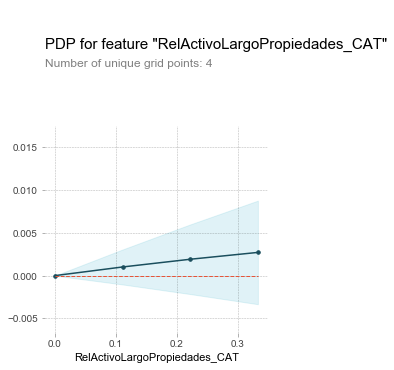

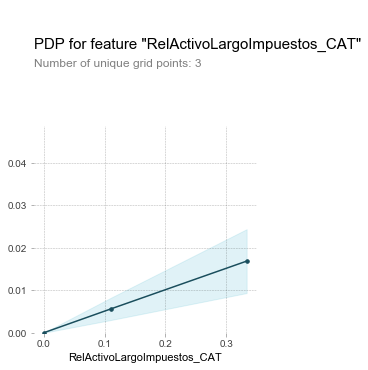

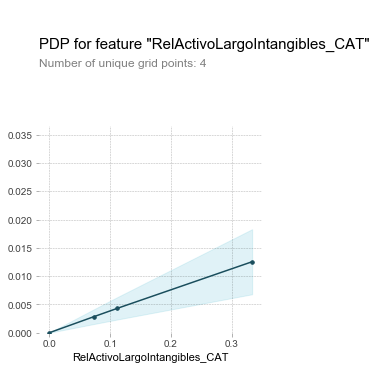

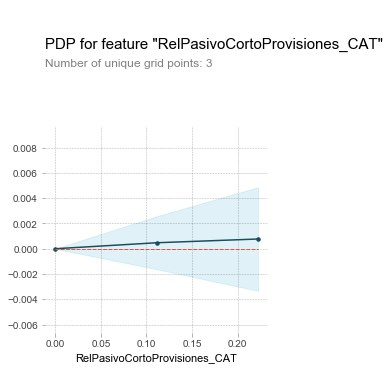

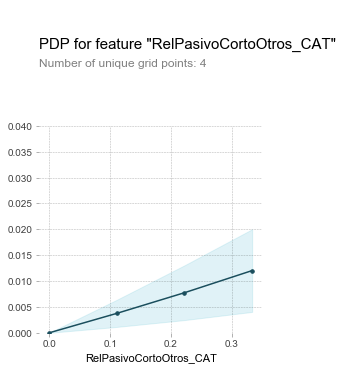

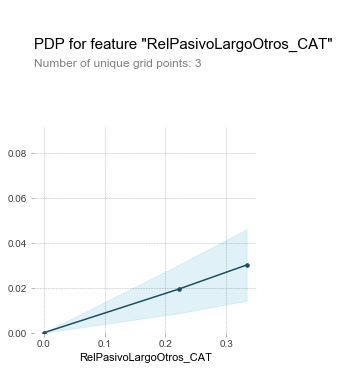

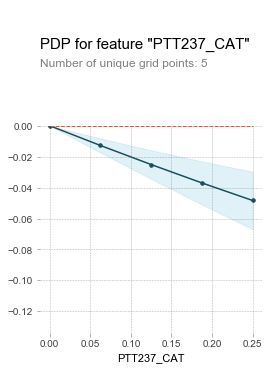

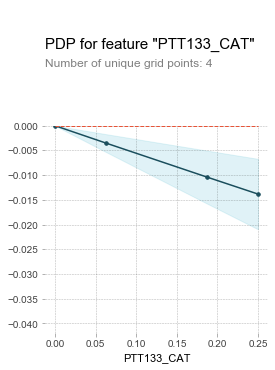

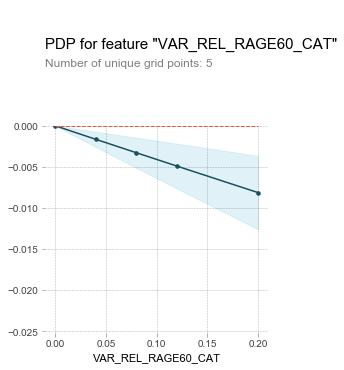

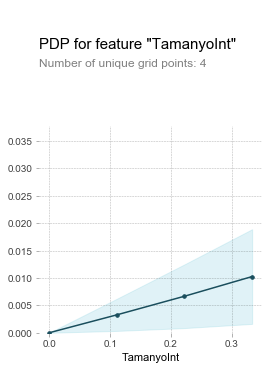

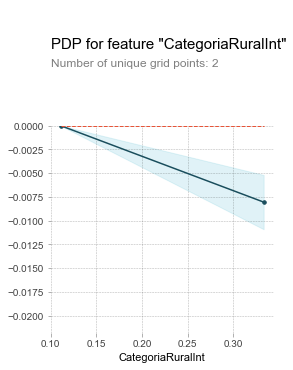

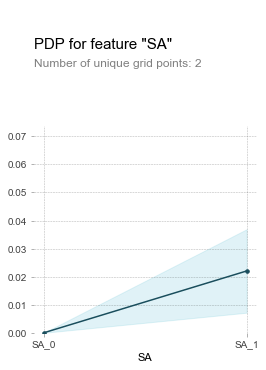

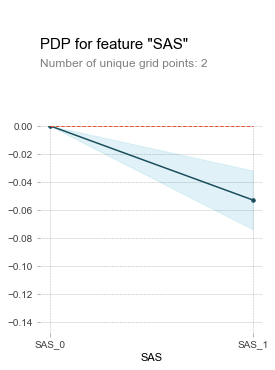

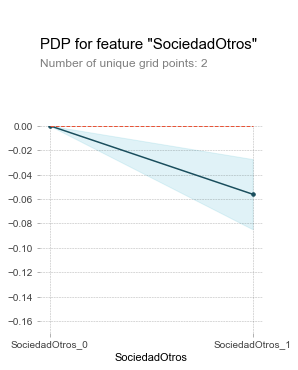

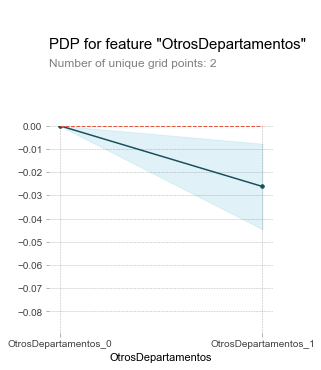

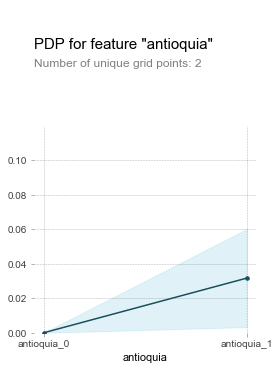

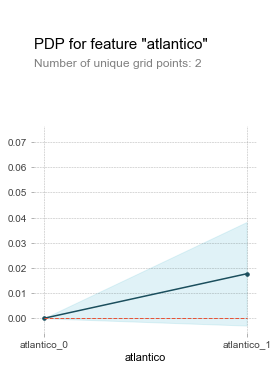

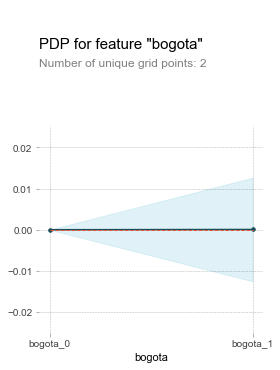

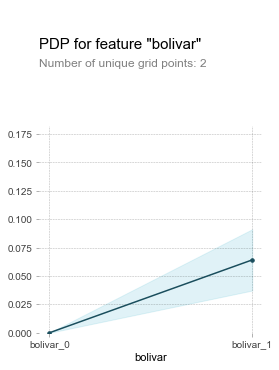

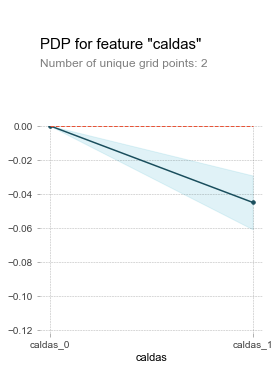

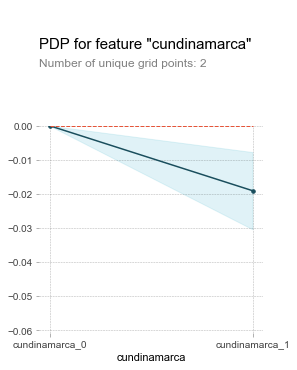

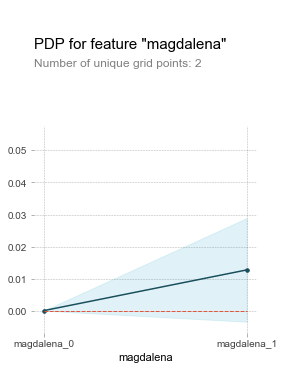

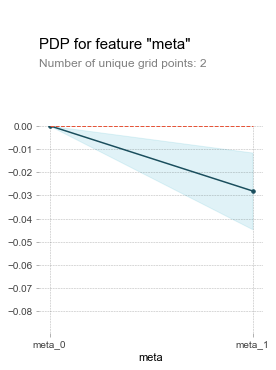

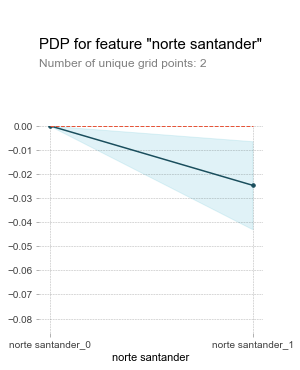

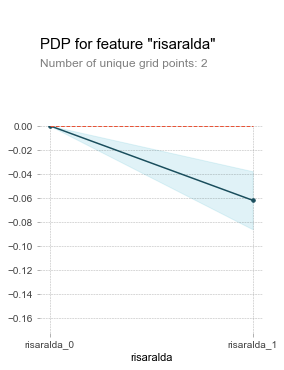

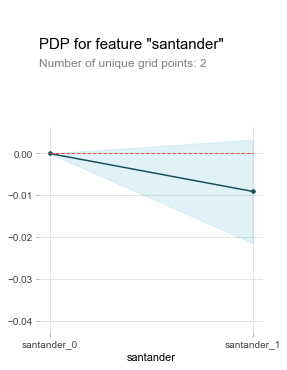

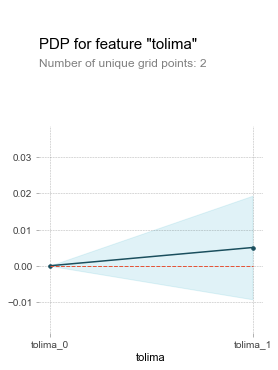

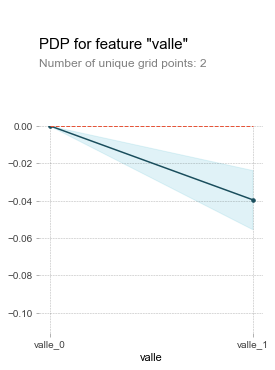

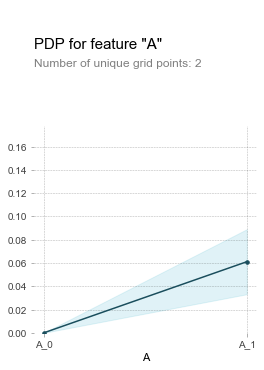

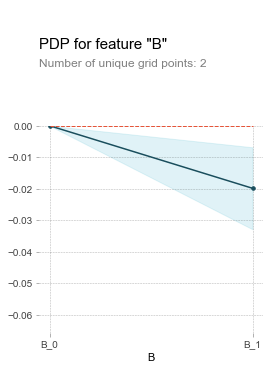

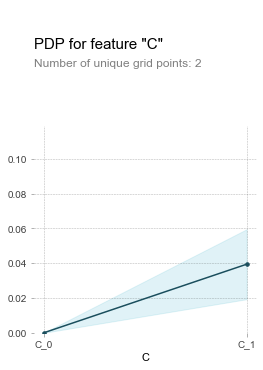

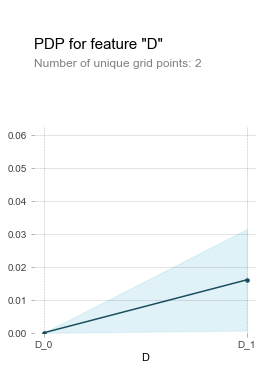

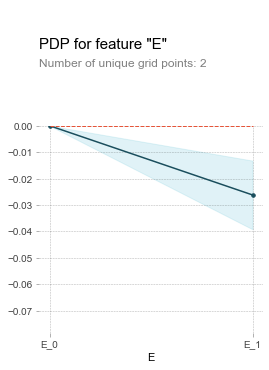

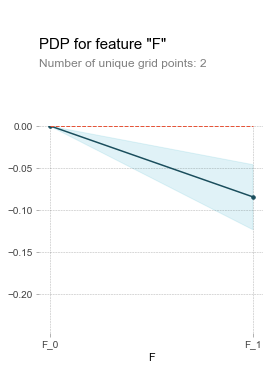

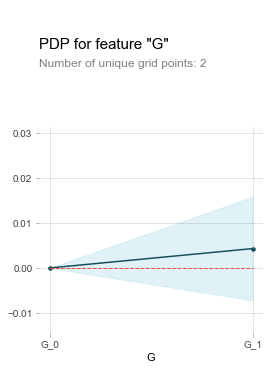

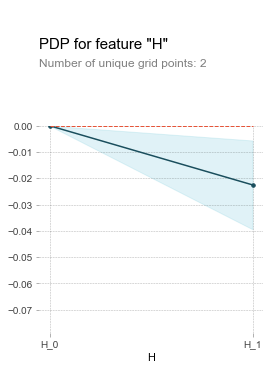

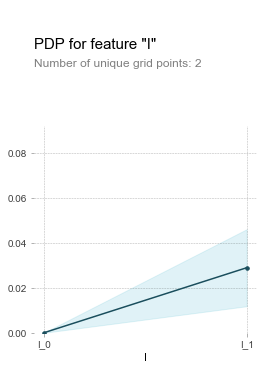

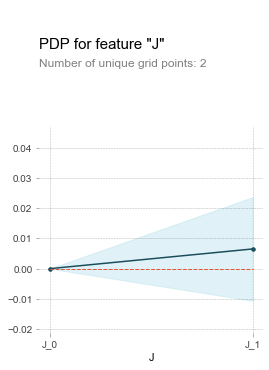

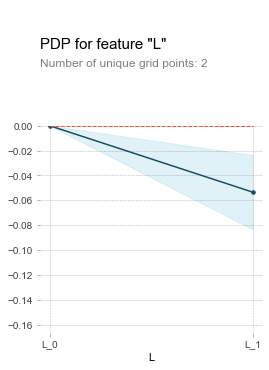

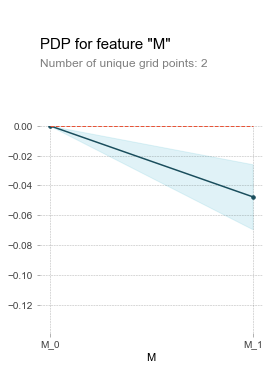

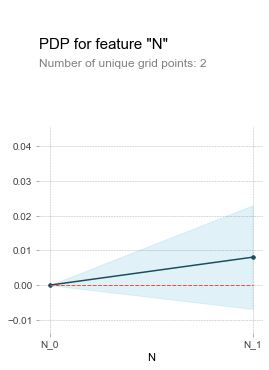

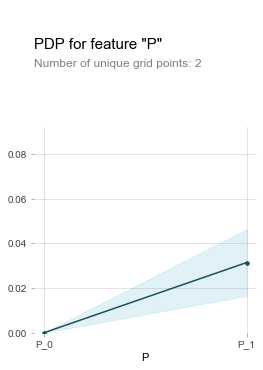

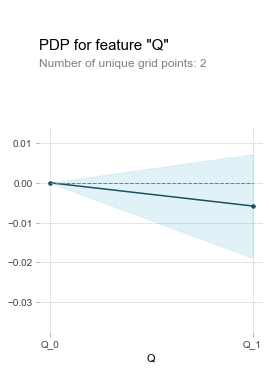

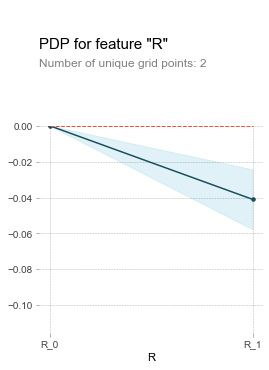

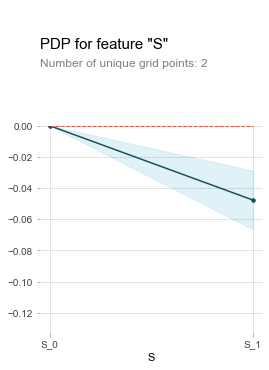

In [80]:
# Partial dependence plots para los modelos de redes neuronales
def plot_nn_pdp(model, x_test, columns):
    for i, e in enumerate(columns):
        pdp_goals = pdp.pdp_isolate(model = model, 
                                dataset = x_test, columns=x_test.columns), 
                                model_features = x_test.columns.tolist(),
                                feature=e)
        # plot NOX pdp
        pdp.pdp_plot(pdp_goals, e, x_quantile=False, plot_pts_dist=False, figsize={6,4})
        
    plt.show()
    

plot_nn_pdp(estimator, pd.DataFrame(sc.transform(x_test_sel.sample(500, random_state=random_seed)), columns=x_test_sel.columns), x_test_sel.columns.tolist())

Las diferencias respecto al modelo SVM son las siguientes:

1. La red neuronal no le da tanta importancia a RAIE (ingresos operacionales). Esta variable no aporta nada, básicamente.
3. RelActivoCortoDeutores produce una disminución de la probabilidad zombi a partir de cierto valor, pero en SVM esta variable tomaba una pendiente positiva.
4. RelActivoLargoPropiedades_CAT también tiene las pendientes invertidas.
5. La ruralidad también. En las redes neuronales, una categoría rural superior (a mayor categoría rural, más urbana es la ciudad) disminuye la probabilidad zombi. En SVM esta variable tenía poco efecto.
6. Respecto a los sectores, solo existen diferencias en D (Suministros).
7. Respecto a los departamentos, no existen diferencias significativas.

Salvo estas diferencias, todas las otras variables se comportan de forma similar, por lo que se puede asegurar que los dos modelos aprenden las mismas características.

Ya por último, se proyectan las explicaciones locales de una instancia de cada grupo de clasificación.

In [ ]:
def create_explainerNN(x_train, class_names):
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(x_train),
        feature_names=x_train.columns,
        class_names=class_names,
        random_state=default_seed,
        mode='regression'
    )
    return explainer


def getLocalInstancesNN(clf,x_test, y_test):
    y_pred = clf.predict(x_test)
    y_test_np = y_test.to_numpy().reshape(-1,1)
    y_pred_np = y_pred.reshape(-1,1)
    TP = (y_test_np == 1) & (y_pred_np >= 0.5)
    FP = (y_test_np == 0) & (y_pred_np >= 0.5)
    TN = (y_test_np == 0) & (y_pred_np < 0.5)
    FN = (y_test_np == 1) & (y_pred_np < 0.5)
    
    ret = {'TP':TP,'FP':FP,'TN':TN, 'FN':FN }
    rangeI = range(0,2)
    return [(key, x_test.iloc[elem].iloc[rangeI]) for key, elem in ret.items()]
   
def explainInstancesNN(clf, x_train, x_test, y_test, class_names):
    explainer = create_explainerNN(x_train, class_names)
    for name, instances in getLocalInstancesNN(clf, x_test, y_test):
        print("Explaining: {0}".format(name))
        for i in range(2):
            exp = explainer.explain_instance(
                data_row=instances.iloc[i], 
                predict_fn=clf.predict
            )

            exp.show_in_notebook(show_table=True)
            
explainInstancesNN(estimator, pd.DataFrame(x_train_nn_norm, columns=x_train_nn.columns), pd.DataFrame(sc.transform(x_test_sel),columns=x_test_sel.columns), y_test, ['No zombi','Zombi'])

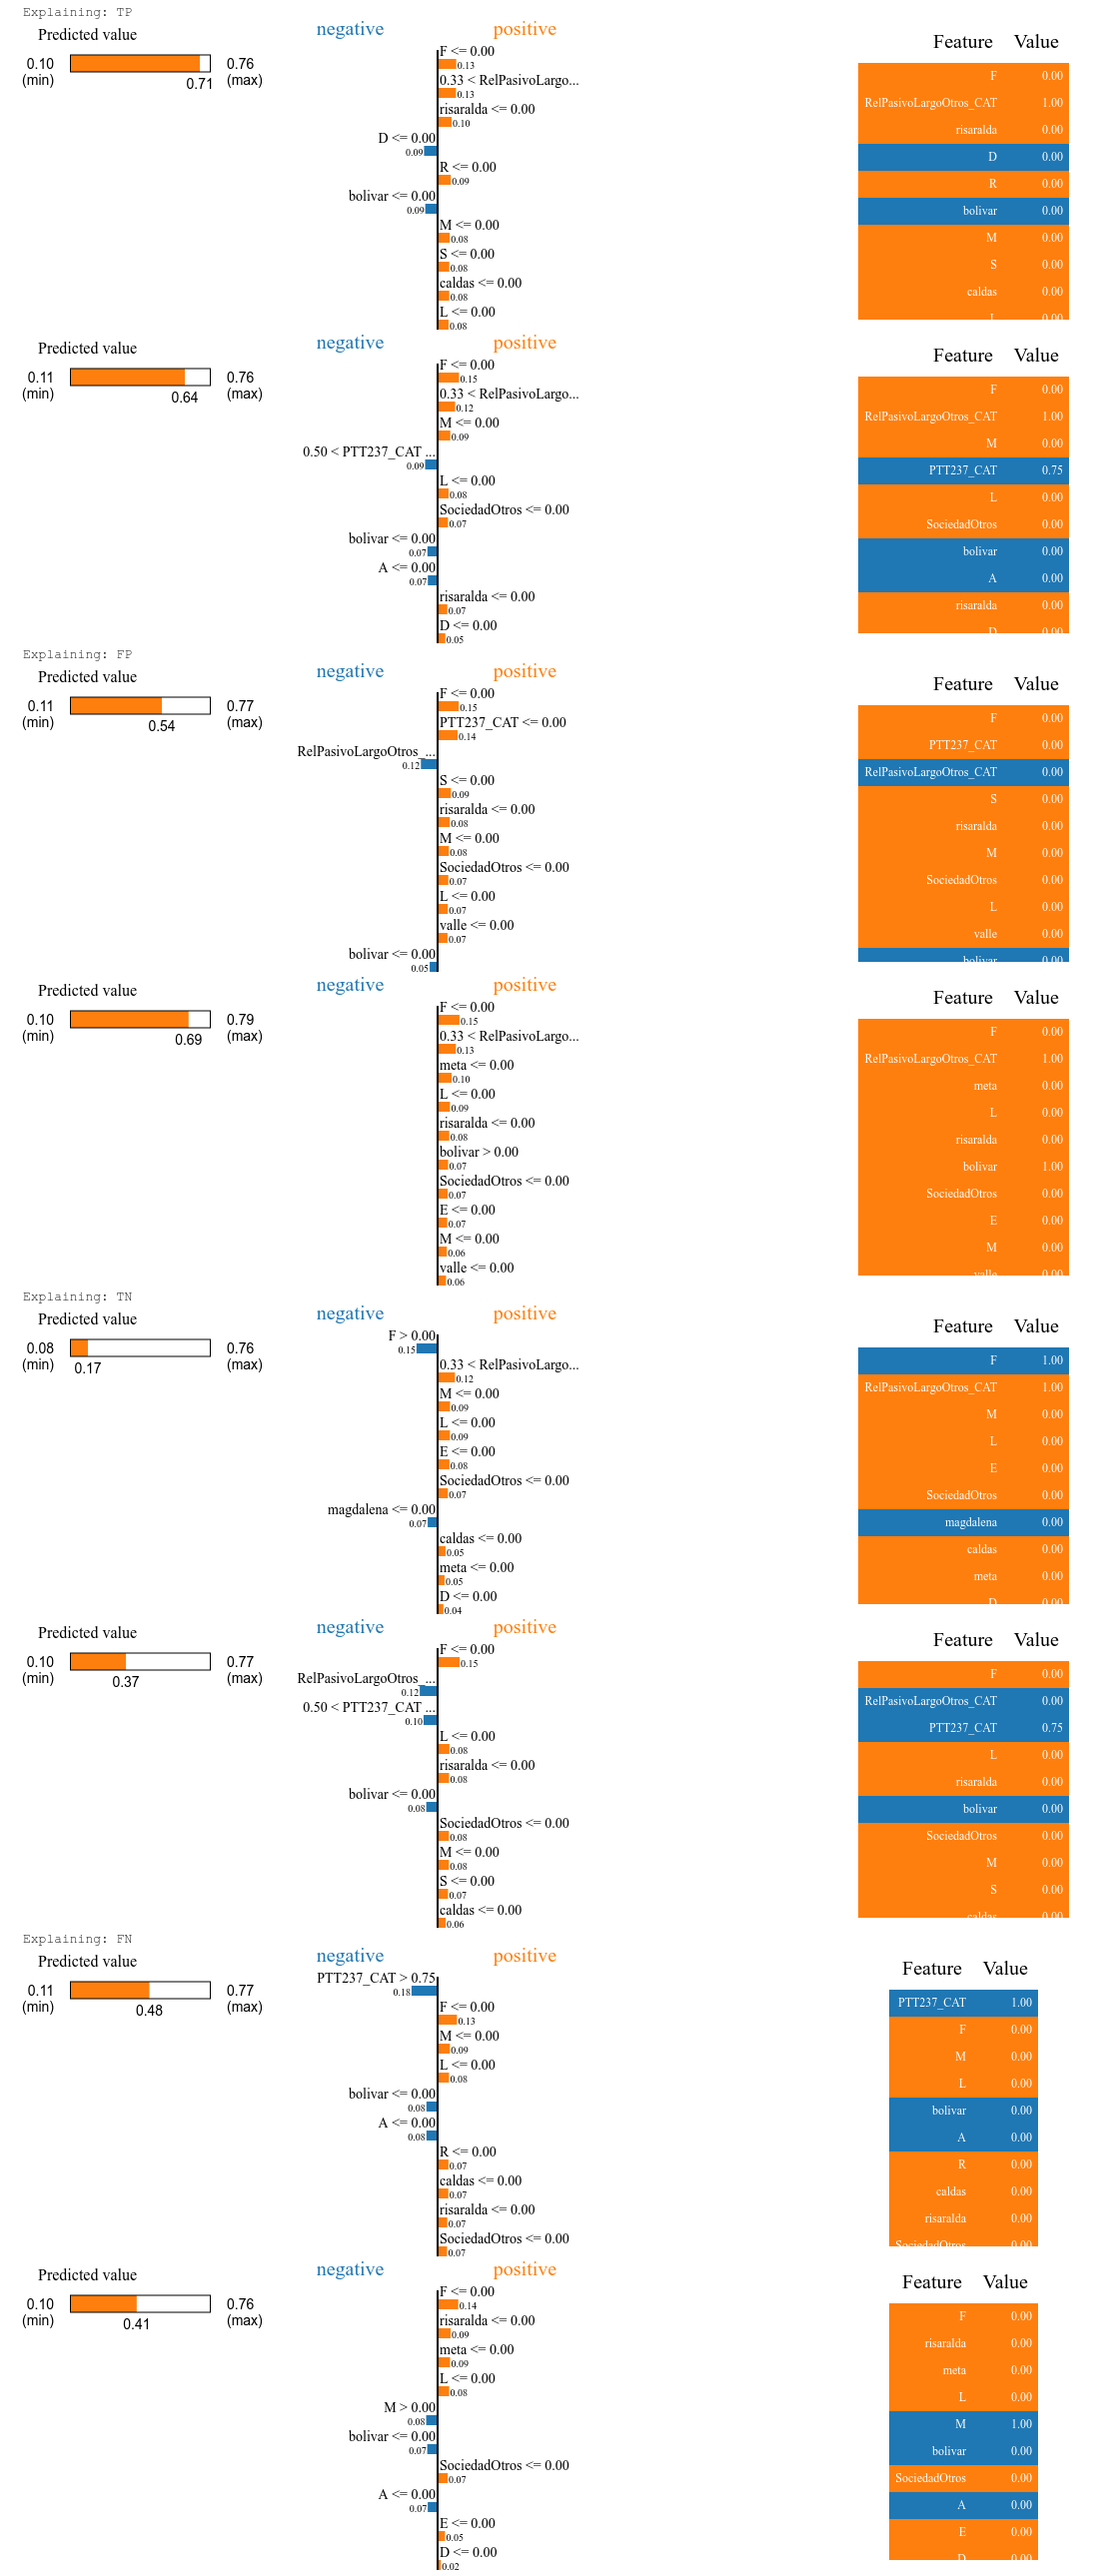

In [95]:
from IPython.display import Image
# Mostrar una imagen
Image(filename='assets/LIME_NN.PNG')

Los falsos positivos son en parte producidos por la no pertenencia a ciertos sectores y departamentos, como se puede observar. 

Los verdaderos positivos son causados por las mismas razones, pero con la diferencia que presentan el pasivo a largo "otros" muy alto en comparación con los falsos positivos, lo que incrementa su predicción zombi.

Respecto a los verdaderos negativos, son causados o bien por pertenecer a F(Construcción), o bien por sus altos niveles de ganancias acumuladas.

Uno de los falsos negativos es engañador por tener unos altos niveles de fondos propios. 

En definitiva, la red toma mucha importancia a los sectores para la clasificación. Puede ser determinante el sector de la empresa, ya que los sectores suman un alto porcentaje a la balanza de predicción. Puede que las instancias que se hayan seleccionado no tengan características financieras relevantes para la clasificación, y por este motivo no salgan en los primeros lugares del explicador LIME.

## Boosting
La técnica del boosting consiste en utilizar varios clasificadores débiles de forma secuencial, consiguiendo que los clasificadores siguientes mejoren secuencialmente el rendimiento de los anteriores.

En adaboost, en cada iteración se identifican las instancias incorrectamente clasificadas, para así incrementar su peso en los siguientes clasificadores. De esta manera, cada iteración para más atención a aquellas instancias incorrectamente clasificadas.

Se parte del dataset reducido, que ha proporcionado buenos resultados en las redes neuronales.

In [82]:
x_train_un, y_train_un = undersample_train(x_train, y_train)
# Crear el modelo
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=default_seed)
# Kfold cross validation con 5 folds
printKFoldResults(kfold_crossvalidation(5, clf, x_train_un, y_train_un))

Fold results:
-----------------------
Exactitud: 0.64
Recall: 0.59
Precisión: 0.68
F1 Score: 0.63
-----------------------
Fold results:
-----------------------
Exactitud: 0.70
Recall: 0.67
Precisión: 0.72
F1 Score: 0.70
-----------------------
Fold results:
-----------------------
Exactitud: 0.68
Recall: 0.65
Precisión: 0.66
F1 Score: 0.66
-----------------------
Fold results:
-----------------------
Exactitud: 0.66
Recall: 0.61
Precisión: 0.68
F1 Score: 0.64
-----------------------
Fold results:
-----------------------
Exactitud: 0.73
Recall: 0.71
Precisión: 0.73
F1 Score: 0.72
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.68
Recall: 0.65
Precisión: 0.70
F1 Score: 0.67


El entrenamiento proporciona resultados notables, aunque se especula que la buena precisión es fruto de la reducción de instancias en el dataset. Se buscan los mejores parámetros para el clasificador.

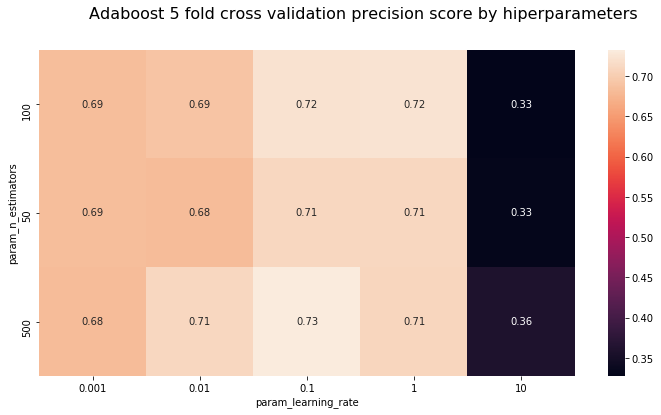

In [83]:
# Crear el modelo
clf = AdaBoostClassifier(random_state=default_seed)
parameters = {
    'n_estimators':[50,100,500],
    'learning_rate':[0.001,0.01,0.1,1,10]   
}

gridSearchHeatMap(clf, x_train_un, y_train_un, parameters, 5, "Adaboost","precision")

Los resultados son muy similares siempre y cuando el learning rate del algoritmo no sea demasiado alto. Para finalizar, se pone a prueba el clasificador con el conjunto de validación o test.

Exactitud: 0.68
Precisión: 0.20
Recall: 0.64
F1 Score: 0.31
Matriz de confusión: 
          No zombi  Zombi
No zombi      1574    736
Zombi          105    186


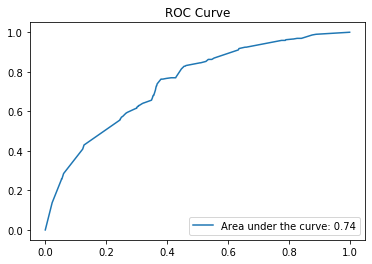

In [84]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=default_seed)
clf.fit(x_train_un, y_train_un)
print_test_classifier(clf, x_test, y_test, ['No zombi','Zombi'])

Los resultados siguen la misma forma que la obtenida durante todo el cuaderno. No se considera realizar un análisis de las características de este clasificador ya que rinde peor que la red neuronal.

## Bagging
El bagging consiste en utilizar varios clasificadores débiles en paralelo, y luego realizar una predicción en cada uno de ellos. Cada clasificador débil entonces vota por su clase preferida.

El encanto de esta técnica es que cada clasificador parte de un set de datos distintos, para minimizar al máximo las posibles correlaciones entre datos. Los sets pueden consistir en una selección de variables, o bien hasta una selección de instancias.

El random forest es el máximo representante de esta técnica. Este algoritmo deja crecer un bosque de árboles, partiendo de distintos sets de datos, e incluso parámetros, y luego los deja votar.


In [85]:
x_train_un, y_train_un = undersample_train(x_train, y_train)
# Crear el modelo
clf = RandomForestClassifier(n_estimators=50,max_depth=10, random_state=default_seed)
# Kfold cross validation con 5 folds
printKFoldResults(kfold_crossvalidation(5, clf, x_train_un, y_train_un))

Fold results:
-----------------------
Exactitud: 0.75
Recall: 0.74
Precisión: 0.79
F1 Score: 0.76
-----------------------
Fold results:
-----------------------
Exactitud: 0.73
Recall: 0.76
Precisión: 0.70
F1 Score: 0.73
-----------------------
Fold results:
-----------------------
Exactitud: 0.73
Recall: 0.78
Precisión: 0.70
F1 Score: 0.74
-----------------------
Fold results:
-----------------------
Exactitud: 0.68
Recall: 0.72
Precisión: 0.66
F1 Score: 0.69
-----------------------
Fold results:
-----------------------
Exactitud: 0.73
Recall: 0.78
Precisión: 0.71
F1 Score: 0.74
-----------------------
Kfold validation results:
-----------------------
Exactitud: 0.73
Recall: 0.76
Precisión: 0.71
F1 Score: 0.73


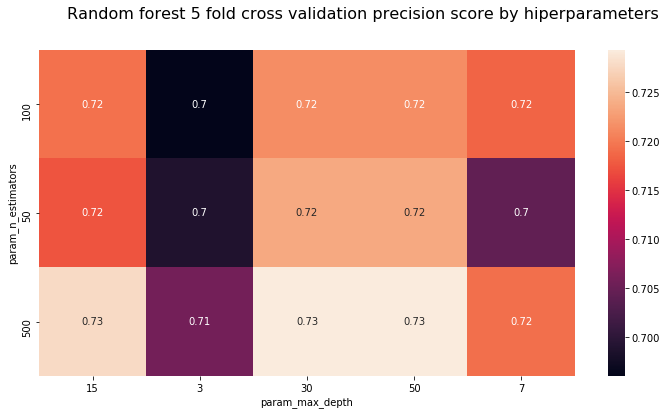

In [86]:
# Crear el modelo
clf = RandomForestClassifier(random_state=default_seed)
parameters = {
    'n_estimators':[50,100,500],
    'max_depth':[3,7,15,30,50]   
}

gridSearchHeatMap(clf, x_train_un, y_train_un, parameters, 5, "Random forest","precision")

No se observan diferencias significativas en el juego de parámetros.

Exactitud: 0.69
Precisión: 0.24
Recall: 0.81
F1 Score: 0.37
Matriz de confusión: 
          No zombi  Zombi
No zombi      1558    752
Zombi           54    237


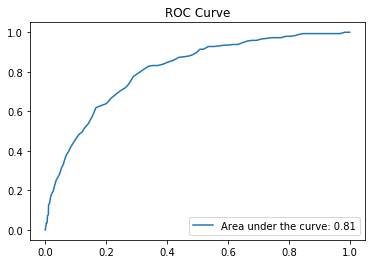

In [87]:
clf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=default_seed)
clf.fit(x_train_un, y_train_un)
print_test_classifier(clf, x_test, y_test, ['No zombi','Zombi'])

Los resultados están al nivel de los mejores modelos de caja negra encontrados. Se pueden explicar las características mediante las "feature_importances" del modelo de random forest, que son la media de las reducciones de impuridad que cada característica aporta a través de todos los árboles del bosque.

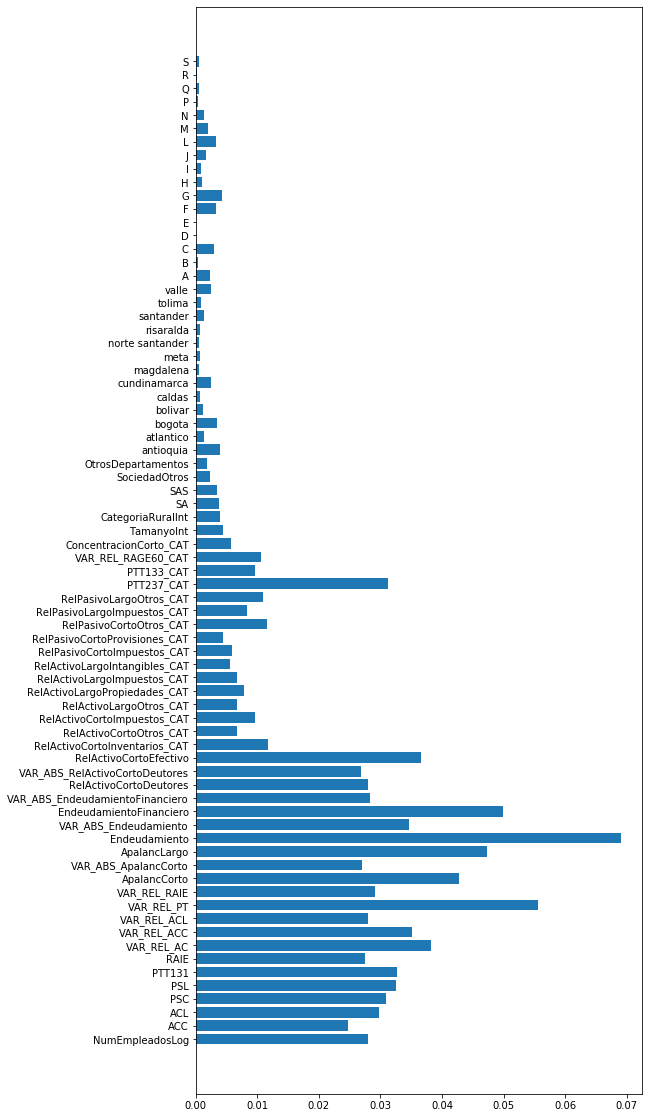

In [88]:
# Cálculo de la media de reducción de impuridad por cada característica.
fig = plt.figure(figsize=(8,20))
plt.barh(x_train.columns.tolist(), clf.feature_importances_)
plt.show()

Los resultados son muy similares a los obtenidos en el cuaderno de etiquetado de datos. Destacan las variables financieras por encima de las básicas (a excepción del número de empleados).

Esto significa que, de media, estas variables separan mejor las clases que las básicas, pero esto también se debe a la baja representabilidad de las variables básicas, ofuscada por el gran número de clases en las secciones y en los departamentos (aunque se hayan reducido).

Por último, se pueden observar la importancia local de las instancias según los grupos de clasificación:

In [ ]:
explainInstances(clf, x_train, x_test, y_test, ['No zombi','Zombi'])

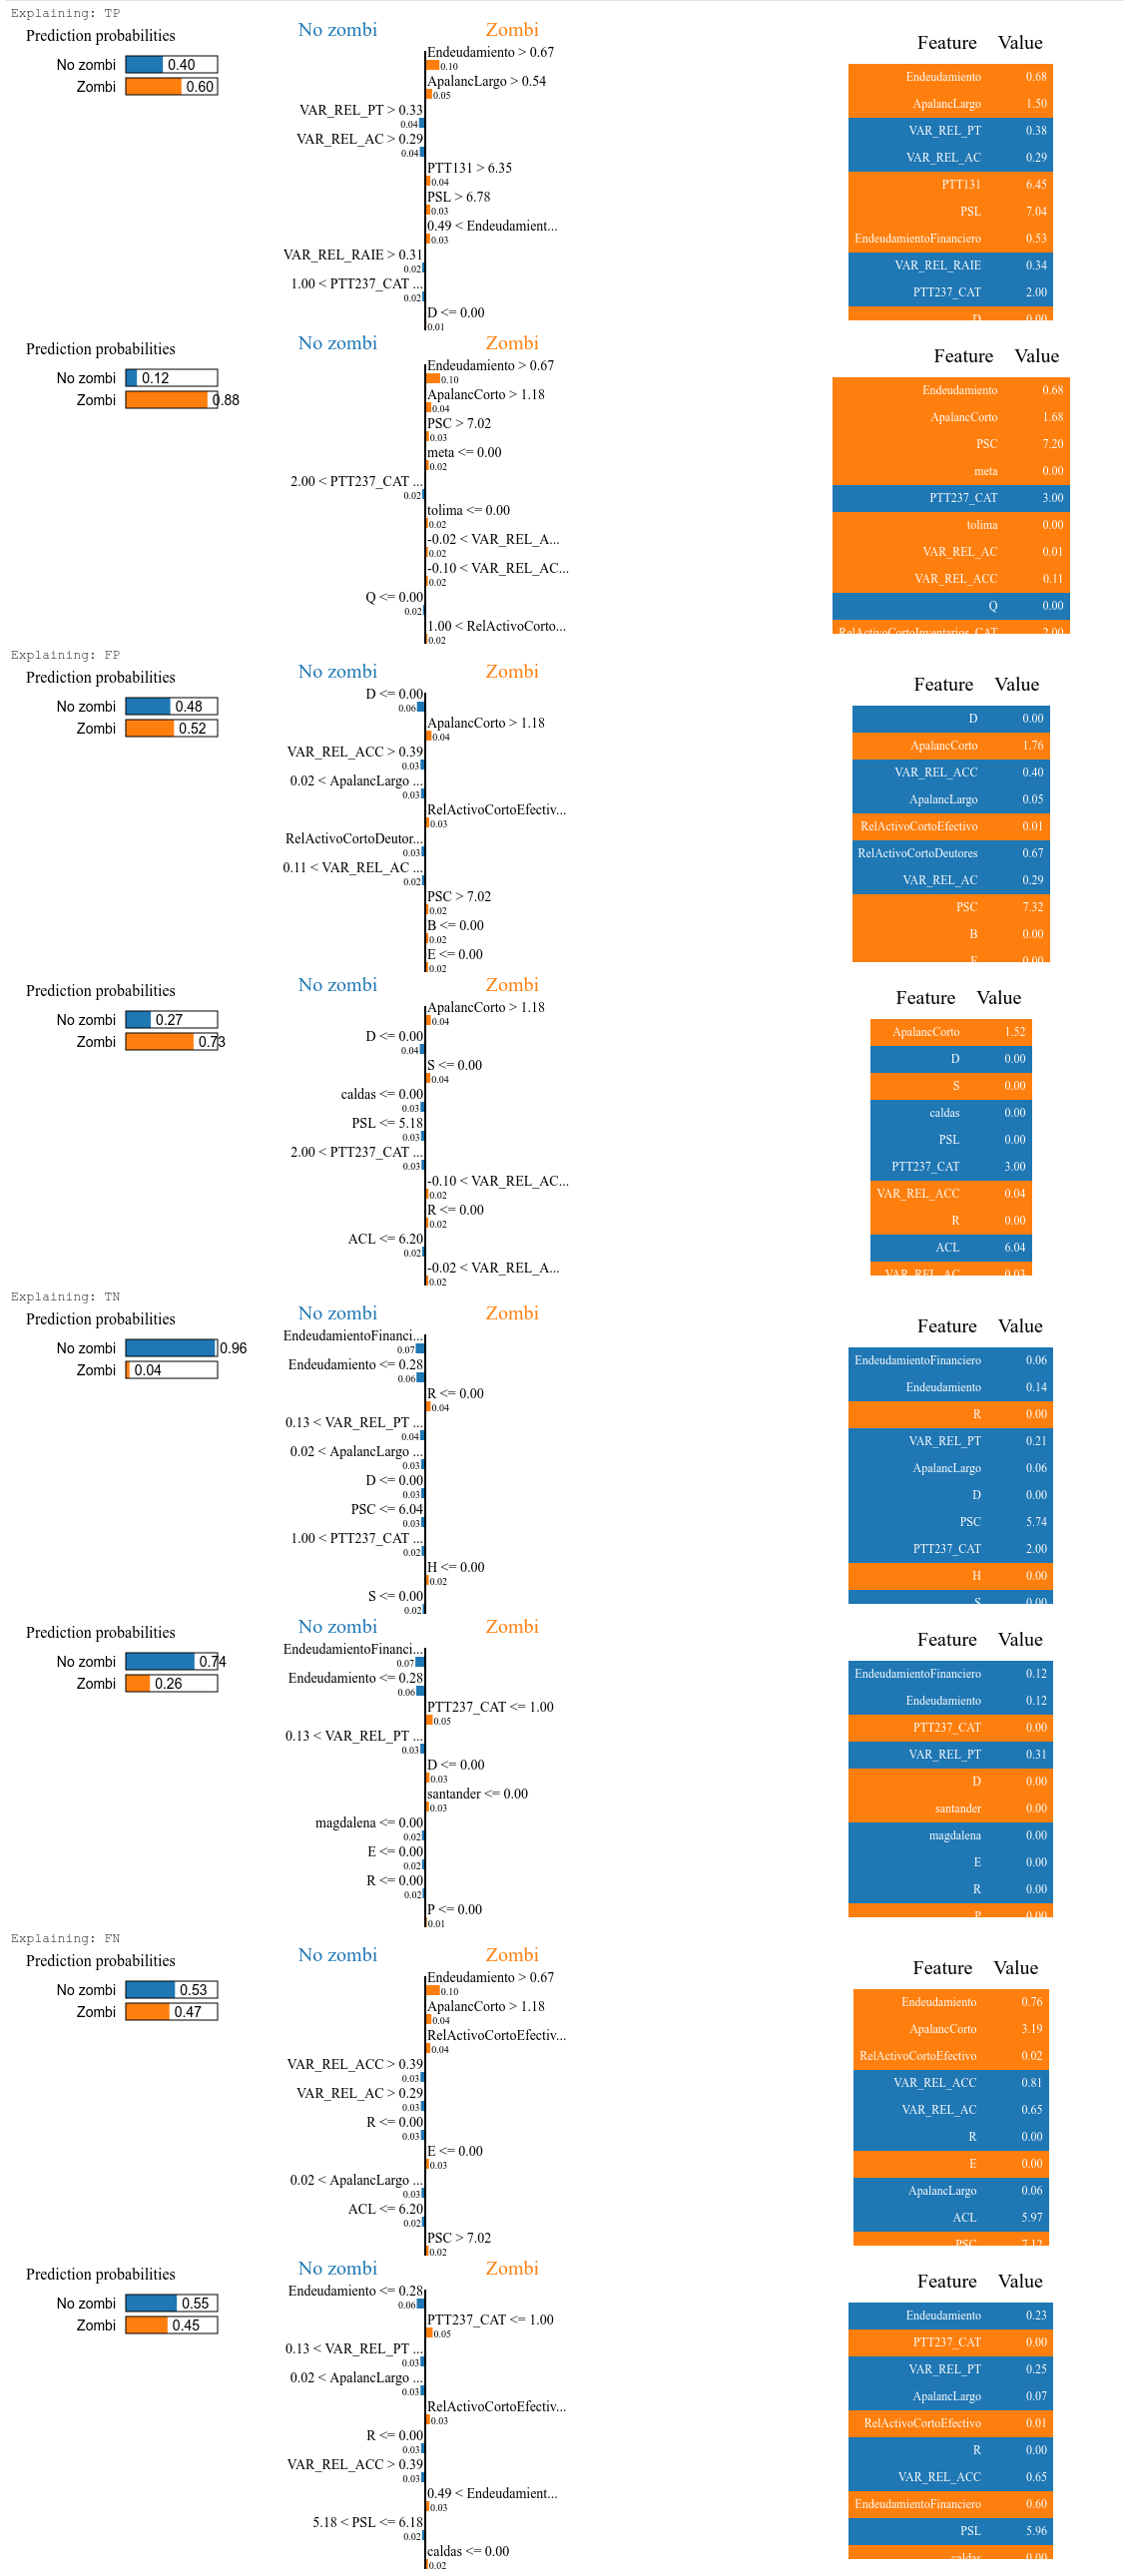

In [96]:
from IPython.display import Image
# Mostrar una imagen
Image(filename='assets/LIME_Bagging.PNG')

En estas instancias se pueden ver nuevos ejemplos de instancias bien y mal clasificadas.

En primer lugar, los verdaderos positivos son en gran parte debido a un gran nivel de endeudamiento, niveles altos de capital social, niveles altos de apalancamiento, y de pasivo en general. 

Los falsos positivos son causados por un alto nivel de apalancamiento, la presencia de pérdidas en el patrimonio, un alto nivel de capital social y de pasivos... 

Como se puede observar, son todos síntomas que deberían presentar las empresas zombis, pero en estos casos la empresa es completamente sana bajo el punto de vista de la definición.

Los verdaderos negativos, como de costumbre, presentan bajos niveles de endeudamiento, bajo apalancamiento, un incremento del patrimonio, de los activos...

Y los falsos negativos se caracterizan por los incrementos en activos, patrimonio... aunque siguen siendo zombis.

En definitiva, el random forest consigue unos resultados similares a todos los algoritmos precedentes. Teniendo en cuenta que utiliza la técnica del boosting, seleccionando diferentes grupos de variables para los distintos árboles, no se puede afirmar que la baja precisión de los modelos sea causada por una selección errónea o por algún problema de datos. 

Todas las pruebas apuntan a que existen variables clave ocultas que permiten refinar el proceso de identificación de empresas zombis. En concreto, discriminar con mayor exactitud aquellas empresas sanas que presentan sintomología zombi como puede ser altos niveles de endeudamiento y pertenencia a sectores y departamentos con alta incidencia zombi. 